## Airbnb Price Prediction

### GOAL
The proposed AI-driven price prediction model aims to surpass existing solutions by integrating additional features and factors that are currently underutilized. This leads to better pricing recommendation to hosts, which removes the need for hosts to rely on third-party software and allows airbnb to retain the costs for dynamic pricing.

### Process
#### Data Ingestion
<li> Dataset containing listings for 8 cities in Canada available via Inside Airbnb. The dataset contains 49,636 listings with 74 different characteristics.</li>
<li> Dataset containing the reviews for listings of all 8 cities, also retrieved from Inside Airbnb. Over 1.5 million reviews were retrieved and used.</li>
<li> The coordinates for town centers for all 8 cities, retrieved via google maps. </li>
<li> The coordinates of 2519 tourist attractions in the 8 selected cities of Canada. <li>

#### Initial Feature Elimination 
<li> Removed any unnecessary columns, renamed columns for better readability and converted price column to float. </li>

#### Exploratory Data Analysis (EDA)
<li> Explored various features of data to identify patterns and visualized using different graphs.</li>

#### Data Preprocessing
<li> Train-test split the data by 80-20 percentages </li>
<li> Took natural log of price </li>
<li> Handled missing values through imputation and removal depending on requirements. </li>
<li> Engineered new features such as days_since columns for host registration, first review and last review dates. </li>
<li> Engineered new features for distance to downtown and number of tourist attractions within a 10km radius for listings</li>
<li> Extracted Amenities using regex </li>
<li> Encoded categorical columns using boolean, ordinal and one-hot encoding depending on requirements </li>

#### Modeling and Evaluation
<li> Built 5 different models. </li>
<li> Linear Models: Linear Regression and Ridge Regression with regularization </li>
<li> Ensemble Models: LightGBM, XGBoost, Random Forest </li>
<li> Evaluated using MSE and R2 scores </li>

#### Model Tuning
<li> Selected LightGBM as a final model</li>
<li> Overfitting and underfitting test - Model was overfitted </li>
<li> Changed how amenities are extracted - reduced overfitting </li>
<li> Removed more features based on domain knowledge - improved accuracy </li>
<li> Used categorical features directly - better model interpretability </li>
<li> Global and local interpretetions showed that last_review_days, first_review_days, and host_listings_count was having a negative effect on price prediction, so we removed that column for better accuracy. </li>
<li> Identified the predictions with highest residuals and interpreted them using SHAP - Results indicate the model's pricing/recommended price is logical, and the original listing price is too high for it's features. </li>
<li> Increased train size - reduced overfitting </li>
<li> Improved parameters - reduced overfitting </li>

#### Model System Development
<li> A subsequent clustering model that displays nearby similar attractions </li>
<li> Implemented K-means clustering </li>

### Data Ingestion

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split, RepeatedKFold
from scipy import stats
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from numpy import logspace
import lightgbm as lgb
import xgboost as xgb
from sklearn.cluster import KMeans
from geopy.distance import great_circle
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading airbnb data of 8 cities
montreal = pd.read_csv('Dataset/Airbnb/Montreal.csv')
newbrunswick = pd.read_csv('Dataset/Airbnb/NewBrunswick.csv')
ottawa = pd.read_csv('Dataset/Airbnb/Ottawa.csv')
quebeccity = pd.read_csv('Dataset/Airbnb/QuebecCity.csv')
toronto = pd.read_csv('Dataset/Airbnb/Toronto.csv')
vancouver = pd.read_csv('Dataset/Airbnb/Vancouver.csv')
victoria = pd.read_csv('Dataset/Airbnb/Victoria.csv')
winnipeg = pd.read_csv('Dataset/Airbnb/Winnipeg.csv')


# Adding a City column to each dataframes
montreal['city'] = 'Montreal'
newbrunswick['city'] = 'New Brunswick'
ottawa['city'] = 'Ottawa'
quebeccity['city'] = 'Quebec City'
toronto['city'] = 'Toronto'
vancouver['city'] = 'Vancouver'
victoria['city'] = 'Victoria'
winnipeg['city'] = 'Winnipeg'

# Merging data from different cities to a single dataframe
airbnb_df = pd.concat([montreal, newbrunswick, ottawa, quebeccity, toronto, vancouver, victoria, winnipeg], ignore_index=True)

Review sentiment scores were calculated separately since they take a very long time due to high size of textual data. They were calculated and aggregated for each listing, and saved into a separate csv file which we will load and merge to our airbnb dataset. This will be made dynamic during the demo and deployment of the model.

In [4]:
# Loading the review sentiment scores
reviews_df = pd.read_csv('Dataset/Sentiment/listing_sentiment_scores.csv')

airbnb_df = pd.merge(airbnb_df, reviews_df, left_on='id', right_on='listing_id', how='left')

In [5]:
# Checking the data size
print("\nThe data size is : {} ".format(airbnb_df.shape))


The data size is : (49636, 78) 


In [6]:
# Checking dataset information
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            49636 non-null  int64  
 1   listing_url                                   49636 non-null  object 
 2   scrape_id                                     49636 non-null  int64  
 3   last_scraped                                  49636 non-null  object 
 4   source                                        49636 non-null  object 
 5   name                                          49636 non-null  object 
 6   description                                   48752 non-null  object 
 7   neighborhood_overview                         27492 non-null  object 
 8   picture_url                                   49636 non-null  object 
 9   host_id                                       49636 non-null 

In [7]:
# Checking what the data looks like
airbnb_df.head()

id                         listing_url       scrape_id last_scraped  \
0  29059  https://www.airbnb.com/rooms/29059  20240323015116   2024-03-23   
1  29061  https://www.airbnb.com/rooms/29061  20240323015116   2024-03-23   
2  36301  https://www.airbnb.com/rooms/36301  20240323015116   2024-03-23   
3  38118  https://www.airbnb.com/rooms/38118  20240323015116   2024-03-23   
4  50479  https://www.airbnb.com/rooms/50479  20240323015116   2024-03-23   

        source                                               name  \
0  city scrape                       Lovely studio Quartier Latin   
1  city scrape                 Maison historique - Quartier Latin   
2  city scrape                  Romantic & peaceful Plateau  loft   
3  city scrape  Beautiful room  with a balcony in front of a parc   
4  city scrape                                     L'Arcade Douce   

                                         description  \
0  CITQ 267153<br />Lovely studio with 1 closed r...   
1  Lovely historic house with plenty of period ch...   
2  Enjoy the best of Montreal  in this romantic, ...   
3                            Nearest metro Papineau.   
4  The appartement is sunny and ideally situated ...   

                               neighborhood_overview  \
0                                                NaN   
1                                                NaN   
2  The neighborhood is very lively while the stre...   
3                                                NaN   
4  Our area is full of life (but our street is qu...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/736399/fa6c31...   125031  ...   
1  https://a0.muscache.com/pictures/9e59d417-4b6a...   125031  ...   
2  https://a0.muscache.com/pictures/26c20544-475f...   381468  ...   
3  https://a0.muscache.com/pictures/213997/763ec1...   163569  ...   
4  https://a0.muscache.com/pictures/miso/Hosting-...   231694  ...   

                       license instant_bookable  \
0  267153, expires: 2024-03-31                f   
1  267153, expires: 2024-03-31                f   
2                          NaN                f   
3                          NaN                f   
4  271530, expires: 2024-04-30                t   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              2                                           2   
1                              2                                           2   
2                              3                                           3   
3                              1                                           0   
4                              2                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            1   

  calculated_host_listings_count_shared_rooms reviews_per_month      city  \
0                                           0              2.69  Montreal   
1                                           0              0.88  Montreal   
2                                           0              0.47  Montreal   
3                                           0              0.10  Montreal   
4                                           0              1.60  Montreal   

  listing_id sentiment_score  
0    29059.0            0.70  
1    29061.0            0.70  
2    36301.0            0.78  
3    38118.0            0.73  
4    50479.0            0.65  

[5 rows x 78 columns]

In [8]:
# Checking for null values in the dataset
airbnb_df.isnull().sum().sort_values(ascending=False)

calendar_updated                49636
neighbourhood_group_cleansed    41746
host_neighbourhood              28125
license                         27612
host_about                      25466
                                ...  
minimum_maximum_nights              0
maximum_maximum_nights              0
minimum_nights_avg_ntm              0
maximum_nights_avg_ntm              0
amenities                           0
Length: 78, dtype: int64

### Initial Feature Elimination

First, we manually eliminated some features that were unnecessary. The features removed were listing_url, scrape_id, last_scraped, source, host_url, host_thumbnail_url, host_picture_url, calendar_updated, and calendar_last_scraped.

Secondly, we eliminate many location-related and listing count related columns since many of them are duplicated, and are mostly filled with null values.

Thirdly, we eliminate redundant columns.

Finally, eliminating columns after model interpretability and tuning the model

In [9]:
feature_elimination_list = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'host_url', 'host_thumbnail_url', 'calendar_updated', 'calendar_last_scraped', 'host_name', 'listing_id', 'host_id', 'neighbourhood_group_cleansed', 'host_neighbourhood', 'host_location', 'neighbourhood', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'review_scores_accuracy', 'bathrooms_text', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'host_about', 'neighborhood_overview', 'host_has_profile_pic', 'picture_url', 'host_picture_url', 'calculated_host_listings_count', 'number_of_reviews']

airbnb_df = airbnb_df.drop(feature_elimination_list, axis=1)

### Renaming Columns

In [10]:
# Mapping new column names
column_mappings = {
    'name': 'title',
    'first_review': 'first_review_date',
    'last_review': 'last_review_date',
    'review_scores_value': 'review_scores_value_for_money',
    'neighbourhood_cleansed': 'neighbourhood',
    'sentiment_score': 'review_sentiment_score'
}

# Renaming columns
airbnb_df.rename(columns=column_mappings, inplace=True)

Converting price to integer

In [11]:
# Removing "$" from price and converting to float
airbnb_df['price'] = airbnb_df['price'].str.replace('[$,]', '', regex=True).astype(float)

### EDA

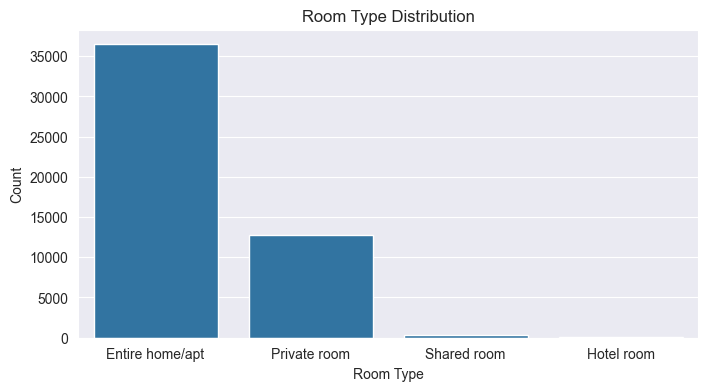

In [12]:
#Room Type Distribution
plt.figure(figsize=(8, 4))
room_type_counts = airbnb_df['room_type'].value_counts()
sns.barplot(x=room_type_counts.index, y=room_type_counts.values)
plt.title('Room Type Distribution')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

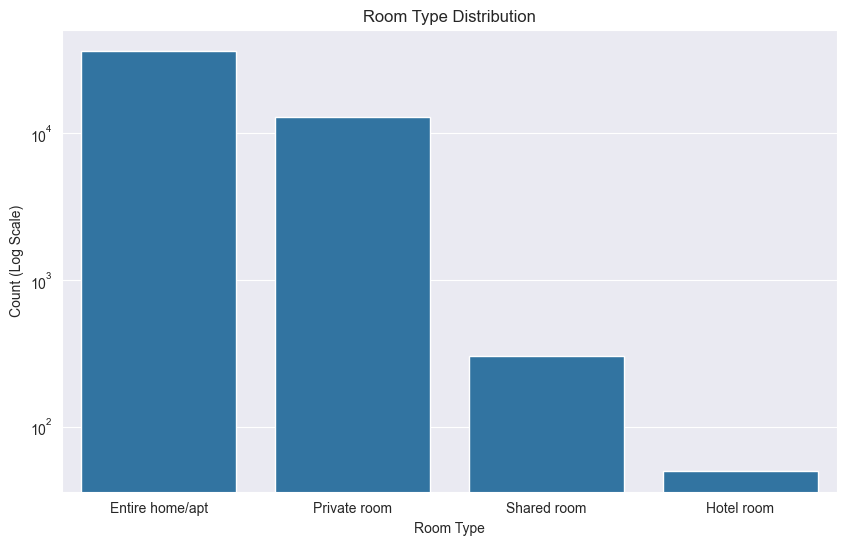

In [13]:
# Room Type Distribution with Log Scale
plt.figure(figsize=(10, 6))
room_type_counts = airbnb_df['room_type'].value_counts()
sns.barplot(x=room_type_counts.index, y=room_type_counts.values)
plt.yscale('log')
plt.title('Room Type Distribution')
plt.xlabel('Room Type')
plt.ylabel('Count (Log Scale)')
plt.show()

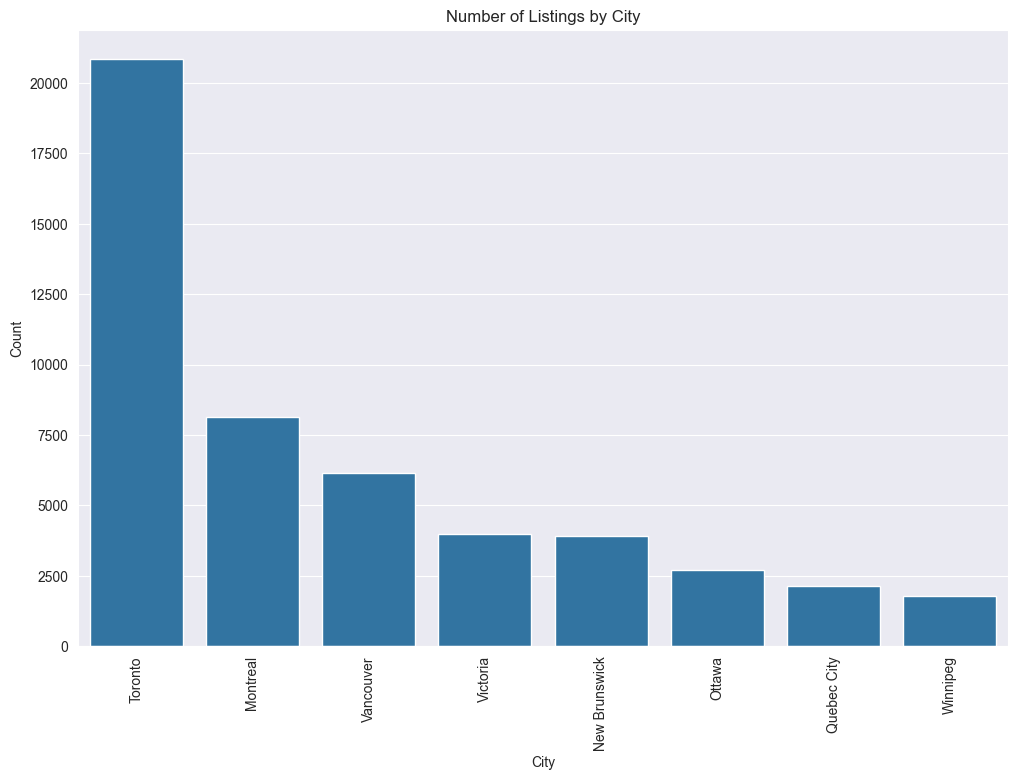

In [14]:
# Plot the number of listings by city
plt.figure(figsize=(12, 8))
sns.countplot(x='city', data=airbnb_df, order=airbnb_df['city'].value_counts().index)
plt.title('Number of Listings by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

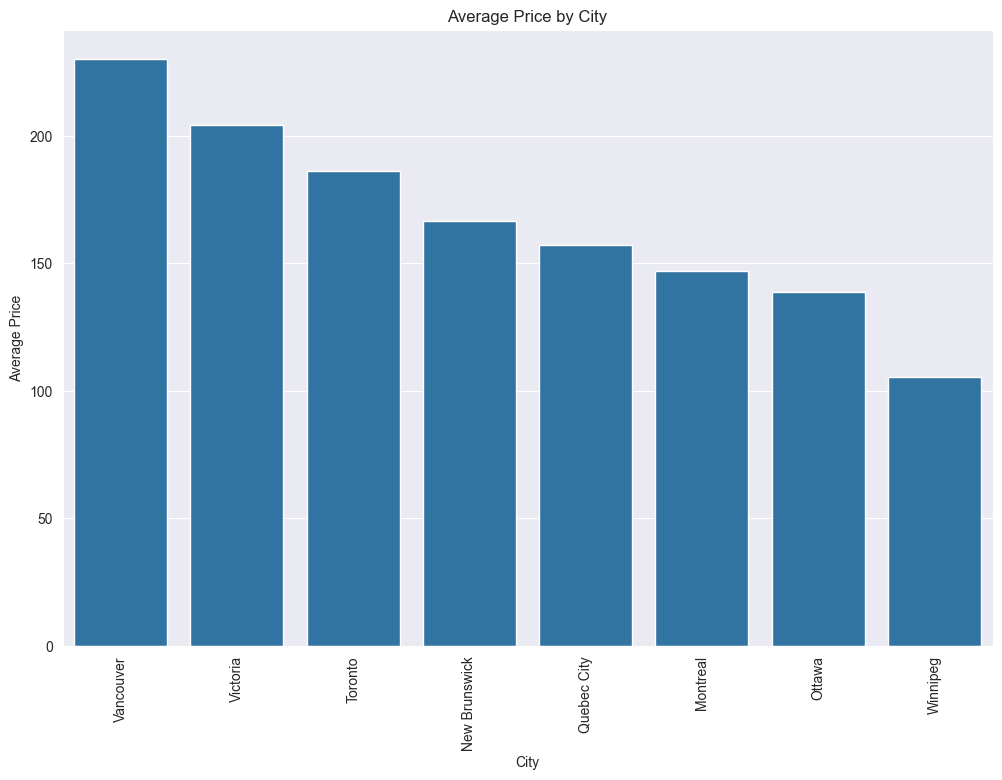

In [15]:
#Average Price by Neighborhood
plt.figure(figsize=(12, 8))
neighborhood_prices = airbnb_df.groupby('city')['price'].mean().sort_values(ascending=False)
sns.barplot(x=neighborhood_prices.index, y=neighborhood_prices.values)
plt.xticks(rotation=90)
plt.title('Average Price by City')
plt.xlabel('City')
plt.ylabel('Average Price')
plt.show()


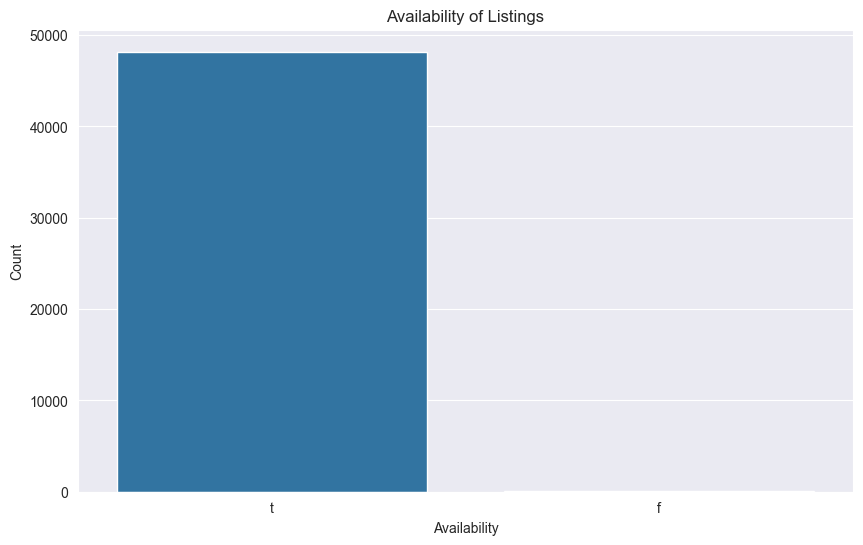

In [16]:
plt.figure(figsize=(10, 6))
availability_counts = airbnb_df['has_availability'].value_counts()
sns.barplot(x=availability_counts.index, y=availability_counts.values)
plt.title('Availability of Listings')
plt.xlabel('Availability')
plt.ylabel('Count')
plt.show()

In [17]:
availability_counts = airbnb_df['has_availability'].value_counts()
availability_counts

has_availability
t    48187
f      110
Name: count, dtype: int64

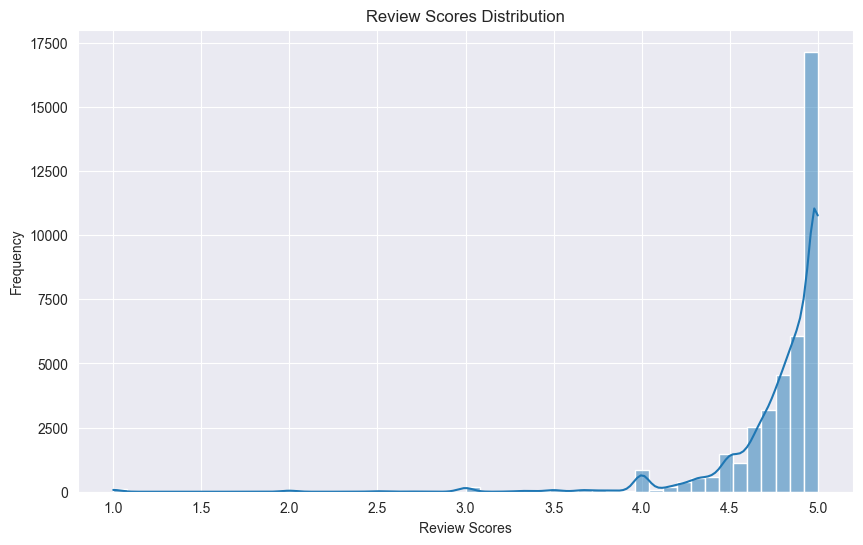

In [18]:
# Review Scores Distribution
plt.figure(figsize=(10, 6))
sns.histplot(airbnb_df['review_scores_rating'], bins=50, kde=True)
plt.title('Review Scores Distribution')
plt.xlabel('Review Scores')
plt.ylabel('Frequency')
plt.show()

Map of number of listings in Canada

In [19]:
# Creating a map centered around New Brunswick
center_lat = 46.5653
center_lon = -66.4619
m = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Adding red dots for each location
for _, row in airbnb_df.sample(1000).iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color='blue', icon='cloud')
    ).add_to(m)

# Displaying the map
m

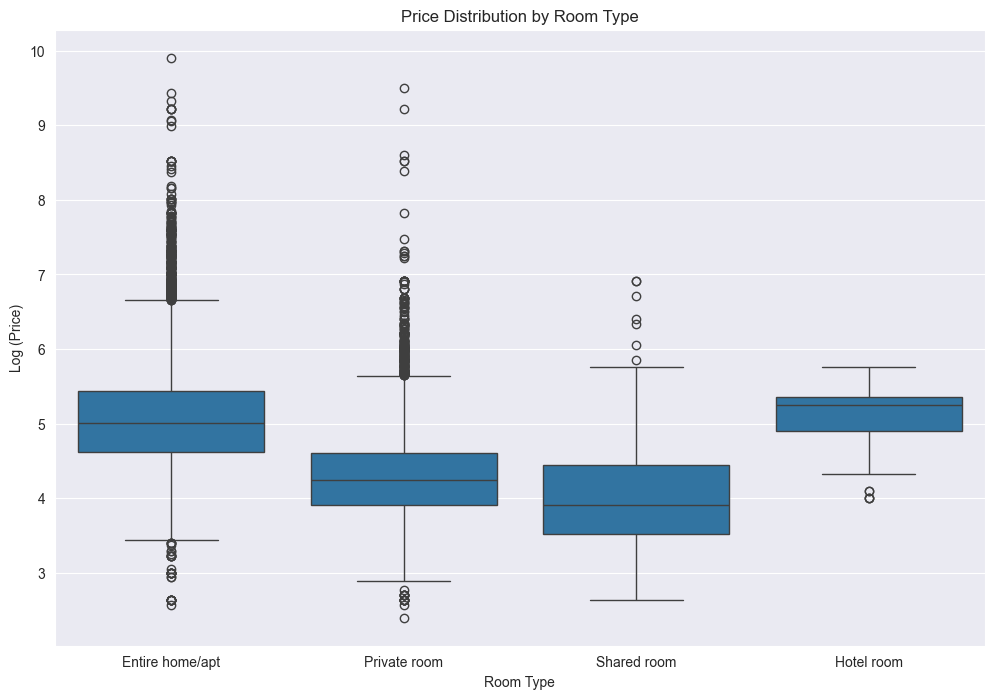

In [20]:
# distribution of prices across different room types.
plt.figure(figsize=(12, 8))
sns.boxplot(x='room_type', y=np.log(airbnb_df['price']), data=airbnb_df)
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Log (Price)')
plt.show()

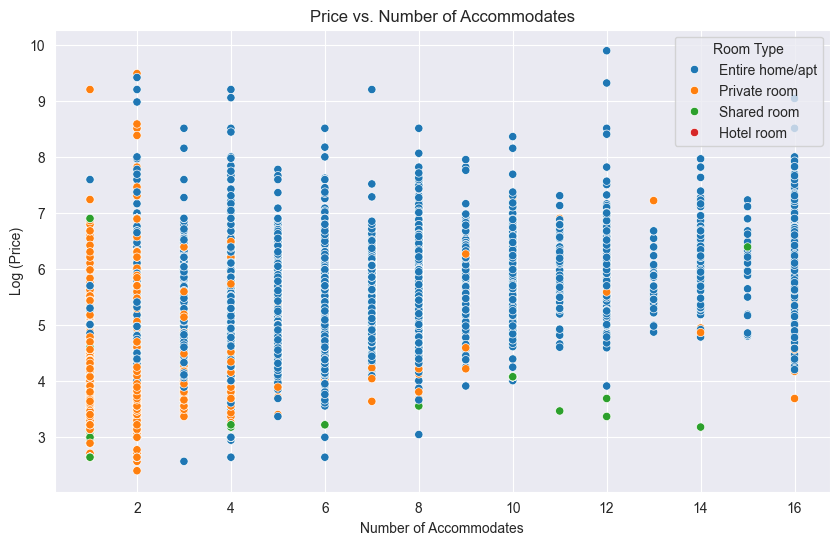

In [21]:
# Relationship between the price and the number of reviews.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accommodates', y=np.log(airbnb_df['price']), data=airbnb_df, hue='room_type')
plt.title('Price vs. Number of Accommodates')
plt.xlabel('Number of Accommodates')
plt.ylabel('Log (Price)')
plt.legend(title='Room Type')
plt.show()

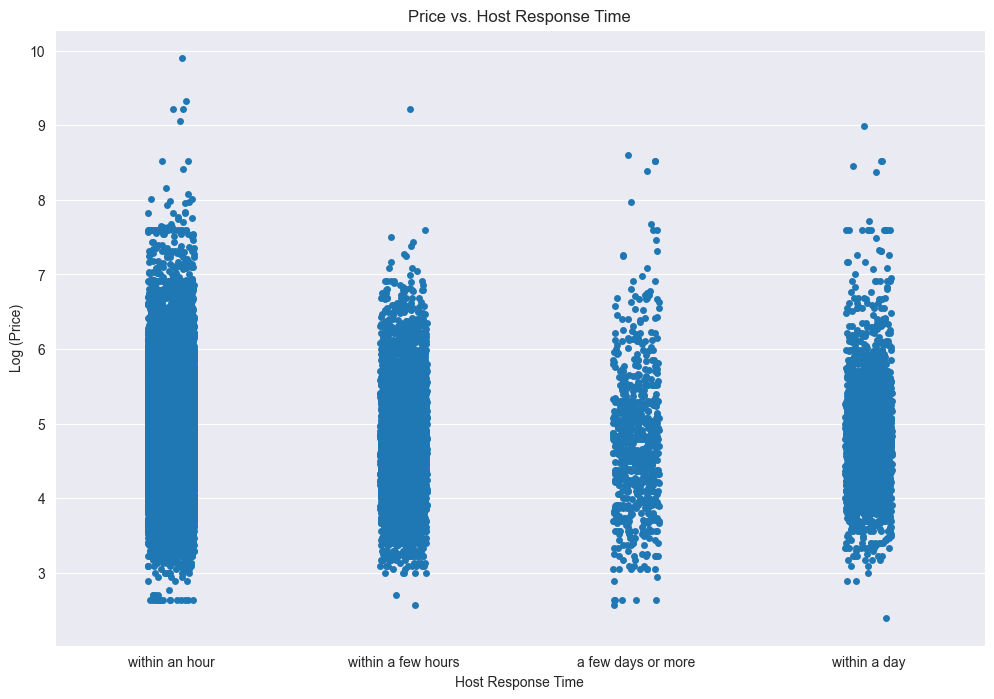

In [22]:
plt.figure(figsize=(12, 8))
sns.stripplot(x='host_response_time', y=np.log(airbnb_df['price']), data=airbnb_df, jitter=True)
plt.title('Price vs. Host Response Time')
plt.xlabel('Host Response Time')
plt.ylabel('Log (Price)')
plt.show()

### Train-Test Split

In [23]:
#data_train, data_test = train_test_split(airbnb_df, test_size=0.80, random_state=42)

# Changing training size to reduce overfitting
data_train, data_test = train_test_split(airbnb_df, test_size=0.01, random_state=42)

In [24]:
# Checking the data size
print("\nThe train data size is : {} ".format(data_train.shape))
print("The test data size is : {} ".format(data_test.shape))


The train data size is : (49139, 40) 
The test data size is : (497, 40) 


### Data Preprocessing

In [25]:
# Checking what the data looks like
data_train.head()

id                                              title  \
1507              32155441  Liv MTL Main-201 Spacious 1BR + Mezz Suite No ...   
11823  1069653548324050953                     71 Williams Downtown Park View   
38326             15481083            Spacious Kitsilano 1 Bedroom (Sleeps 4)   
32028   933532471021940547                          Home sweet home, Toronto.   
3928    675380962217924551  Downtown Cozy Corner *1BR* Bell Centre & Night...   

                                             description  host_since  \
1507   Main-201: Spacious 1BR + Mezzanine Suite in do...  2016-05-25   
11823  Enjoy staying in a beautiful modernized Victor...  2021-07-09   
38326  This modern apartment is located right on the ...  2015-09-07   
32028  Welcome to our beautiful spacious oasis. Newly...  2017-01-09   
3928   Welcome, Montreal travelers! <br />Make home a...  2020-09-29   

      host_response_time host_response_rate host_acceptance_rate  \
1507      within an hour               100%                  98%   
11823     within an hour                93%                  99%   
38326     within an hour               100%                 100%   
32028     within an hour               100%                 100%   
3928      within an hour               100%                 100%   

      host_is_superhost                host_verifications  \
1507                  t  ['email', 'phone', 'work_email']   
11823                 f                ['email', 'phone']   
38326                 t                ['email', 'phone']   
32028                 f  ['email', 'phone', 'work_email']   
3928                  f                ['email', 'phone']   

      host_identity_verified  ... review_scores_rating  \
1507                       t  ...                 4.97   
11823                      t  ...                  NaN   
38326                      t  ...                 4.87   
32028                      t  ...                  NaN   
3928                       t  ...                 4.76   

       review_scores_cleanliness  review_scores_checkin  \
1507                        4.91                   4.95   
11823                        NaN                    NaN   
38326                       4.85                   4.89   
32028                        NaN                    NaN   
3928                        4.69                   4.71   

      review_scores_communication review_scores_location  \
1507                         4.95                   4.81   
11823                         NaN                    NaN   
38326                        4.87                   4.86   
32028                         NaN                    NaN   
3928                         4.90                   4.78   

       review_scores_value_for_money                      license  \
1507                            4.78  295748, expires: 2025-02-28   
11823                            NaN                          NaN   
38326                           4.73                          NaN   
32028                            NaN                          NaN   
3928                            4.68  313182, expires: 2025-05-11   

       instant_bookable           city review_sentiment_score  
1507                  f       Montreal                   0.73  
11823                 t  New Brunswick                    NaN  
38326                 f      Vancouver                   0.85  
32028                 f        Toronto                    NaN  
3928                  t       Montreal                   0.65  

[5 rows x 40 columns]

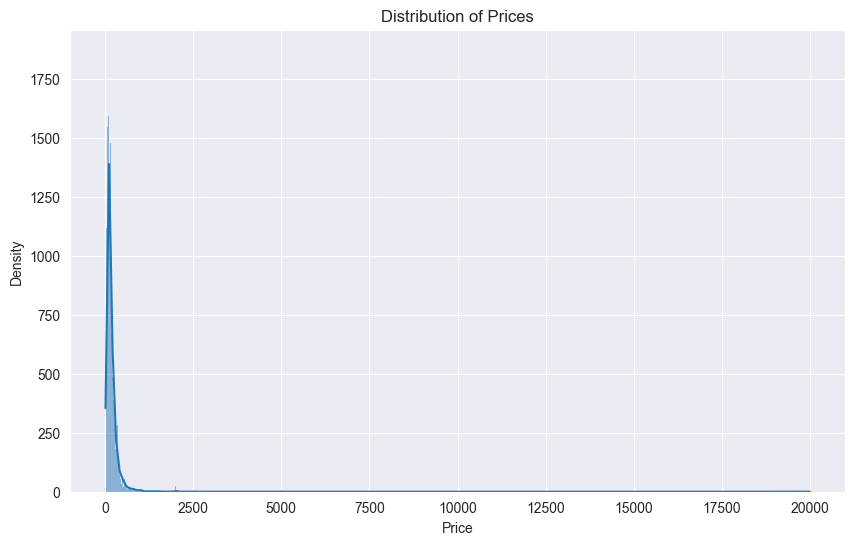

In [26]:
# Plotting a histogram of target variable
plt.figure(figsize=(10,6))
sns.histplot(data_train['price'], kde=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Prices')
plt.show()

The prices for the listings in the dataset are greatly skewed to the right as shown above. This causes a non-linear relationship between the price and features.

To solve this issue, we take the natural logarithm of the price to make the effective relationship non-linear, while still preserving the linear model. This will be very important when testing different regression models. The results of this are shown below.

In [27]:
# Converting values in price column to its natural logarithm
data_train['price'] = np.log(data_train['price'])

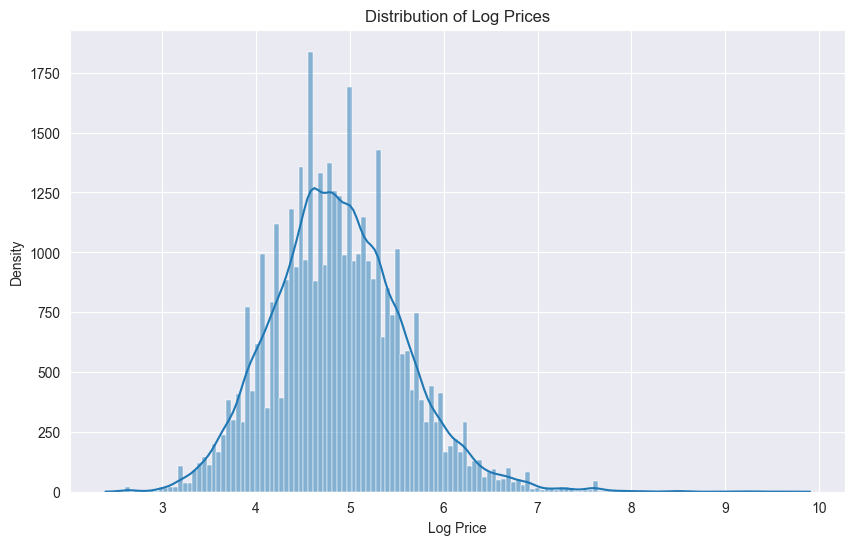

In [28]:
# Plotting a histogram of the log of price
plt.figure(figsize=(10,6))
sns.histplot(data_train['price'], kde=True)
plt.xlabel('Log Price')
plt.ylabel('Density')
plt.title('Distribution of Log Prices')
plt.show()

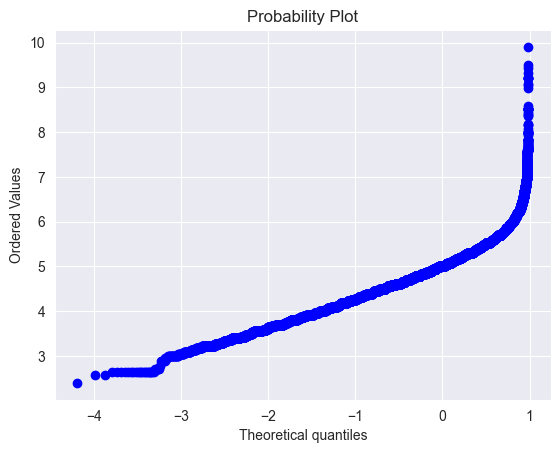

In [29]:
# The QQ-plot
fig = plt.figure()
res = stats.probplot(data_train['price'], plot=plt)
plt.show()

In [30]:
# Identify and drop non-numeric columns
non_numeric_columns = data_train.select_dtypes(include=['object']).columns
data_train_numeric = data_train.drop(non_numeric_columns, axis=1)

corr_mx = data_train_numeric.corr()
corr_mx["price"].sort_values(ascending=False)

price                            1.000000
accommodates                     0.571161
bedrooms                         0.498289
beds                             0.416100
bathrooms                        0.365510
review_sentiment_score           0.266905
review_scores_location           0.188017
review_scores_cleanliness        0.154637
review_scores_rating             0.148429
review_scores_value_for_money    0.102577
review_scores_communication      0.099444
availability_30                  0.078521
latitude                         0.070929
review_scores_checkin            0.059960
availability_60                  0.045372
availability_90                  0.022112
maximum_nights                   0.008723
availability_365                -0.006335
id                              -0.028776
minimum_nights                  -0.119693
longitude                       -0.168397
Name: price, dtype: float64

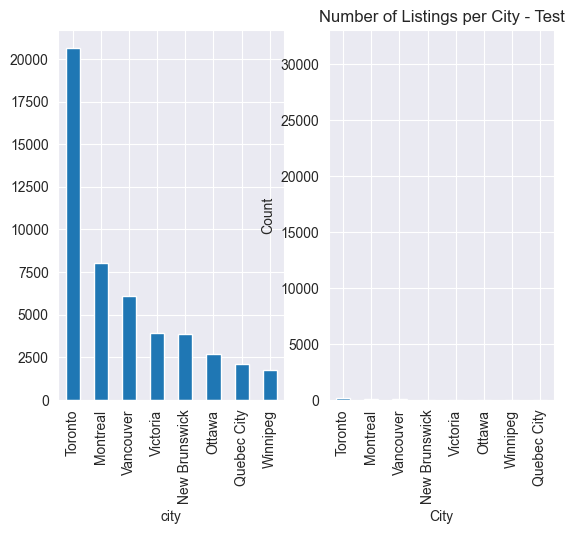

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

data_train['city'].value_counts().plot(kind='bar', ax=ax1)
plt.title('Number of Listings per City - Train')
plt.xlabel('City')
plt.ylabel('Count')


data_test['city'].value_counts().plot(kind='bar', ax=ax2)
plt.title('Number of Listings per City - Test')
plt.xlabel('City')
plt.ylabel('Count')
plt.ylim(0,33000 )
plt.show()

The ratio between listings in each city in Train set vs Test set seem to be similar, which is good!

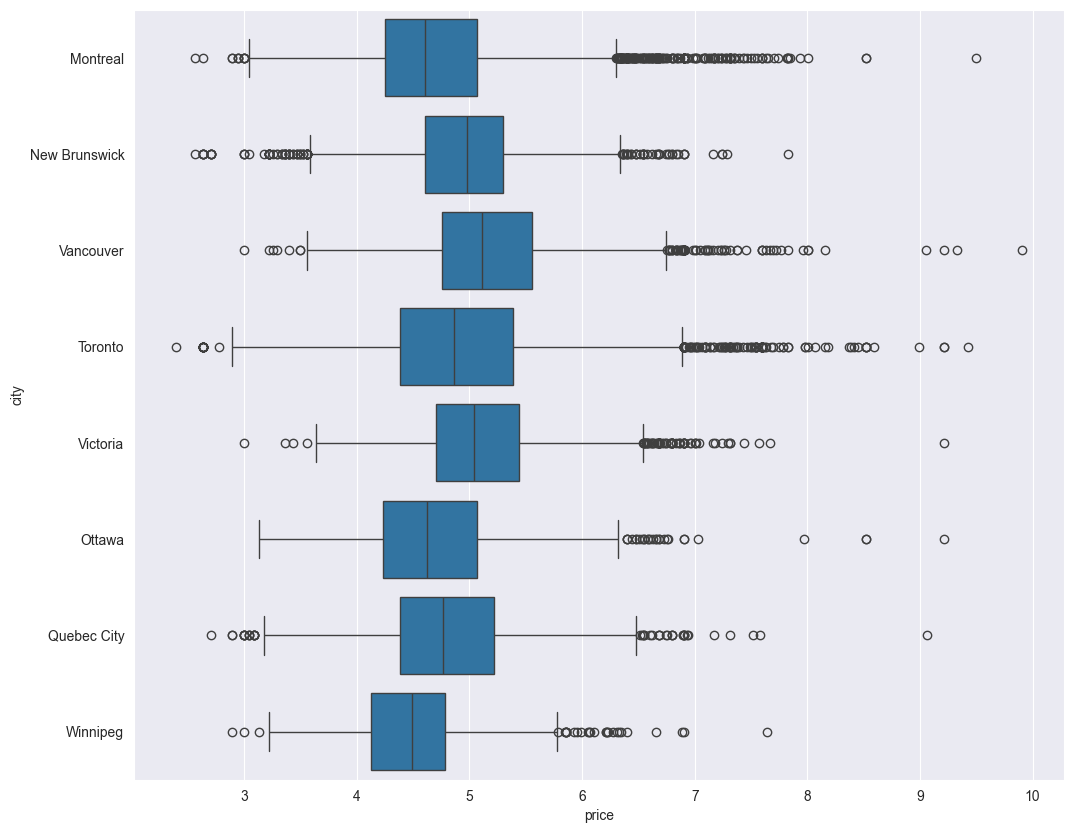

In [32]:
NEIdata = data_train.copy()
plt.figure(figsize = (12, 10))
sns.boxplot(y = 'city', x = 'price',  data = NEIdata, orient="h")
xt = plt.xticks()

### Handling Missing Values

In [33]:
# Checking for null values in the dataset
data_train.isnull().sum().sort_values(ascending=False)

license                          27323
review_sentiment_score           11782
host_response_time               10210
host_response_rate               10210
review_scores_value_for_money    10124
review_scores_location           10124
review_scores_checkin            10123
review_scores_communication      10122
review_scores_cleanliness        10121
last_review_date                 10077
first_review_date                10077
review_scores_rating             10075
host_acceptance_rate              8100
beds                              7977
price                             7972
bathrooms                         7932
bedrooms                          2090
has_availability                  1320
description                        879
host_is_superhost                  521
host_since                           2
host_verifications                   2
host_identity_verified               2
accommodates                         0
longitude                            0
city                     

The null in license column means that the listing doesn't have any license, so filled the column with said information.

In [34]:
# Fill null value with unlicensed
data_train['license'].fillna('Unlicensed', inplace=True)

Dropping all rows that don't have price because it doesn't help the model if it is filled in any way to make correct predictions

In [35]:
# Drop rows with empty price
data_train = data_train.dropna(subset=['price'])

Dropping records with null reviews so that we have more accurate prediction

In [36]:
data_train = data_train.dropna(subset=['review_sentiment_score'])
data_train = data_train.dropna(subset=['review_scores_rating'])

Similarly, filling null values in first and last review dates with today's date where review count is 0. This will be important during data encoding.

Filling null values in host_is_superhost and 'availability' with "f" since the missing values are not random, and just corresponds to none.

In [37]:
data_train['host_is_superhost'] = data_train['host_is_superhost'].fillna('f')
data_train['has_availability'] = data_train['has_availability'].fillna('f')

Filling null values in host_response_time to mode of the feature

In [38]:
data_train['host_response_time'] = data_train['host_response_time'].fillna(data_train['host_response_time'].mode()[0])

Filling null values in remaining columns with median

In [39]:
# Remove % sign and convert to numeric for the following columns
data_train['host_response_rate'] = pd.to_numeric(data_train['host_response_rate'].str.replace('%', ''))
data_train['host_acceptance_rate'] = pd.to_numeric(data_train['host_acceptance_rate'].str.replace('%', ''))

# Creating a list of required columns
numeric_columns = [
    'host_response_rate',
    'host_acceptance_rate',
    'bedrooms', 'beds', 
    'review_scores_value_for_money', 
    'review_scores_location', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_cleanliness', 
    'bathrooms'
]

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_train[column].median()
    data_train[column].fillna(median_value, inplace=True)   

In [40]:
# Rechecking null values
data_train.isnull().sum().sort_values(ascending=False)

description                      349
first_review_date                  2
last_review_date                   2
id                                 0
review_scores_rating               0
has_availability                   0
availability_30                    0
availability_60                    0
availability_90                    0
availability_365                   0
review_scores_cleanliness          0
minimum_nights                     0
review_scores_checkin              0
review_scores_communication        0
review_scores_location             0
review_scores_value_for_money      0
license                            0
instant_bookable                   0
city                               0
maximum_nights                     0
price                              0
title                              0
neighbourhood                      0
host_since                         0
host_response_time                 0
host_response_rate                 0
host_acceptance_rate               0
h

We will clean up the description field during data encoding.

In [41]:
# Checking the data size
print("\nThe train data size is : {} ".format(data_train.shape))


The train data size is : (30499, 40) 


## Feature Engineering

### Feature Extraction

##### Adding days since columns using the date columns

In [42]:
current_date = datetime.now()

# Converting date columns
data_train['host_since'] = pd.to_datetime(data_train['host_since'])

# Calculating values and storing in a new column
data_train['host_since_days'] = (current_date - data_train['host_since']).dt.days

# Dropping date columns
data_train.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

##### Adding distance to downtown and number of nearby attractions

In [43]:
# Define downtown coordinates for each city
downtown_coords = {
    'Montreal': (45.5017, -73.5673),
    'New Brunswick': (45.9636, -66.6372),  # Fredericton
    'Ottawa': (45.4215, -75.6972),
    'Quebec City': (46.8139, -71.2080),
    'Toronto': (43.6532, -79.3832),
    'Vancouver': (49.2827, -123.1207),
    'Victoria': (48.4284, -123.3656),
    'Winnipeg': (49.8951, -97.1384)
}

In [44]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [45]:
# Calculate distance to downtown using broadcasting
for city, (lat, lon) in downtown_coords.items():
    mask = data_train['city'] == city
    data_train.loc[mask, 'distance_to_downtown'] = haversine_distance(
        data_train.loc[mask, 'latitude'].values, 
        data_train.loc[mask, 'longitude'].values, 
        lat, 
        lon
    )

Scraped Tourist attractions data using the overpass api and stored to a csv file

In [46]:
# Load attraction data
attractions_df = pd.read_csv('Dataset/Locations/canadian_tourist_attractions.csv')
attractions_df['city'] = attractions_df['city'].str.title().str.replace('_', ' ')
attractions_df.head()

city                              name   latitude  longitude  \
0  Montreal  Musée des Beaux-Arts de Montréal  45.498697 -73.579385   
1  Montreal              Belvédère Léo-Ayotte  45.523223 -73.568744   
2  Montreal    Musée des ondes Emile Berliner  45.477550 -73.592403   
3  Montreal                            Orbite  45.523473 -73.536689   
4  Montreal                           Spirale  45.525468 -73.534699   

         type  
0      museum  
1   viewpoint  
2      museum  
3  attraction  
4  attraction

We want to calculate the total number of attractions that are in a 10km radius of each listing and use the number as a feature.

In [47]:
# Count attractions within 10km using broadcasting
def count_attractions_within_radius(airbnb_lat, airbnb_lon, attractions, radius_km=10):
    distances = haversine_distance(airbnb_lat, airbnb_lon, attractions['latitude'].values, attractions['longitude'].values)
    return np.sum(distances <= radius_km)

# Calculate attractions within 10km for each Airbnb listing
attraction_counts = []
for city in data_train['city'].unique():
    attractions_city = attractions_df[attractions_df['city'] == city]
    if not attractions_city.empty:
        attraction_counts.extend(data_train[data_train['city'] == city].apply(
            lambda row: count_attractions_within_radius(row['latitude'], row['longitude'], attractions_city),
            axis=1
        ))
    else:
        attraction_counts.extend([0] * len(data_train[data_train['city'] == city]))

data_train['nearby_attractions'] = attraction_counts

### Data Encoding

In [48]:
# Selecting non numerical columns from the dataframe
non_numerical_columns = data_train.select_dtypes(exclude=['number']).columns.tolist()
categorical_columns = data_train[non_numerical_columns]

categorical_columns.head()

title  \
1507   Liv MTL Main-201 Spacious 1BR + Mezz Suite No ...   
38326            Spacious Kitsilano 1 Bedroom (Sleeps 4)   
3928   Downtown Cozy Corner *1BR* Bell Centre & Night...   
31420                         Sunshine filled apartment!   
25697                   Cozy Studio Apartment in Toronto   

                                             description host_response_time  \
1507   Main-201: Spacious 1BR + Mezzanine Suite in do...     within an hour   
38326  This modern apartment is located right on the ...     within an hour   
3928   Welcome, Montreal travelers! <br />Make home a...     within an hour   
31420  1 bedroom and office apartment that is cozy an...       within a day   
25697  Enjoy your stay in a studio suite in a quaint ...     within an hour   

      host_is_superhost                host_verifications  \
1507                  t  ['email', 'phone', 'work_email']   
38326                 t                ['email', 'phone']   
3928                  f                ['email', 'phone']   
31420                 f                ['email', 'phone']   
25697                 t                ['email', 'phone']   

      host_identity_verified                 neighbourhood  \
1507                       t         Le Plateau-Mont-Royal   
38326                      t                     Kitsilano   
3928                       t                   Ville-Marie   
31420                      t            Caledonia-Fairbank   
25697                      f  Runnymede-Bloor West Village   

            property_type        room_type  \
1507   Entire rental unit  Entire home/apt   
38326  Entire rental unit  Entire home/apt   
3928         Entire condo  Entire home/apt   
31420         Entire home  Entire home/apt   
25697  Entire rental unit  Entire home/apt   

                                               amenities has_availability  \
1507   ["Paid parking lot off premises", "Smart lock"...                t   
38326  ["Hot water kettle", "Private patio or balcony...                t   
3928   ["Microwave", "Hot water kettle", "Hair dryer"...                t   
31420  ["Shampoo", "Electric stove", "Bathtub", "Paid...                t   
25697  ["Shampoo", "Hair dryer", "Conditioner", "Keyp...                t   

                           license instant_bookable       city  
1507   295748, expires: 2025-02-28                f   Montreal  
38326                   Unlicensed                f  Vancouver  
3928   313182, expires: 2025-05-11                t   Montreal  
31420              STR-2307-GJYBHS                f    Toronto  
25697              STR-2107-HTMHHL                f    Toronto

Converting boolean columns and picture url columns to 0s and 1s

In [49]:
for boolean_column in ['host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_train[boolean_column] = data_train[boolean_column].map(lambda s: False if s == "f" else True)

Changing data in license column to licensed and unlicensed and converting to boolean

In [50]:
# Changing data
data_train['license'] = data_train['license'].map(lambda s: False if s == "Unlicensed" else True)

Ordinal Encoding host_response_time since there is a clear order

In [51]:
# Define the order of categories
categories = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

# Initialize OrdinalEncoder with the defined categories
ordinal_encoder = OrdinalEncoder(categories=[categories])

# Fit and transform the 'host_response_time' column
data_train['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_train[['host_response_time']])

# Dropping the categorical column
data_train.drop(columns=['host_response_time'], inplace=True)

One hot encoding property_type, city, and room_type

We are one-hot encoding these columns, but keeping the original because the final model we selected, Light GBM inherently supports categorical columns.

In [52]:
# data_train = pd.get_dummies(data_train, columns=['property_type'], prefix='property')
# data_train = pd.get_dummies(data_train, columns=['city'], prefix='city')
# data_train = pd.get_dummies(data_train, columns=['room_type'], prefix='room_type')

# Create the dummy variables without dropping the original column
dummy_vars = pd.get_dummies(data_train['property_type'], prefix='property')
# Concatenate the original DataFrame with the dummy variables
data_train = pd.concat([data_train, dummy_vars], axis=1)
# Create the dummy variables without dropping the original column
dummy_vars = pd.get_dummies(data_train['city'], prefix='city')
# Concatenate the original DataFrame with the dummy variables
data_train = pd.concat([data_train, dummy_vars], axis=1)
# Create the dummy variables without dropping the original column
dummy_vars = pd.get_dummies(data_train['room_type'], prefix='room_type')
# Concatenate the original DataFrame with the dummy variables
data_train = pd.concat([data_train, dummy_vars], axis=1)

One hot encoding verifications

In [53]:
# Function to safely evaluate strings
def safe_eval(x):
    if isinstance(x, str):
        return eval(x)
    return x

# Extract unique items from the list in the column
unique_items = set(item for sublist in data_train['host_verifications'].apply(safe_eval) for item in sublist)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_items:
    column_name = item + "_verification"
    data_train[column_name] = data_train['host_verifications'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_train.drop('host_verifications', axis=1, inplace=True)

### Feature Extraction

##### Cleaning and Extracting amenities

In [54]:
# Flatten the lists and extract unique items
unique_items = set(item for sublist in data_train['amenities'].apply(safe_eval) for item in sublist if item)

In [55]:
# Print the total number of unique items
print("Total number of unique items:", len(unique_items))

Total number of unique items: 9837


In [56]:
# Commenting this because the output is too long. Was used for testing.
#print(unique_items)

Since there are too many unique values, many of which are similar to each other, we will create categories and use regex to replace the amenities values in the column to reduce the overall unique amenities.

To do this, we will create categories and check and update the keyword_patterns below so that we assign all unique values to a key (category) before applying the regex to the amenities column.

In [57]:
#Define keywords and corresponding regex patterns
keywords_patterns = {
    'tv': r'\b(TV|HDTV|Roku|chromecast)\b',
    'netflix': r'\b(Netflix|Amazon|hulu|disney+)\b',
    'pool': r'\b(Pool|Swimming pool)\b',
    'oven': r'\b(Oven|microwave)\b',
    'stove': r'\b(Stove|stove)\b',
    'wifi': r'\b(Wifi)\b',
    'toiletries': r'\b(Toiletries|Shampoo|Brush|Conditioner|soap|wash|shower gel)\b',
    'parking': r'\b(parking|carport)\b',
    'sound_system': r'\b(SoundSystem|Sound System|speakers|speaker|piano|record player)\b',
    'coffee_maker': r'\b(coffee|coffee-maker|coffeemaker|espresso)\b',
    'grill': r'\b(Grill|BBQ)\b',
    'workspace': r'\b(Workspace|Workspaces)\b',
    'closet': r'\b(Closet|storage|wardrobe|dresser)\b',
    'gym': r'\b(Exercise|yoga|elliptical|bike|bikes|gym)\b',
    'refrigerator': r'\b(Refrigerator|refrigerator|freezer|ice machine|fridge)\b',
    'housekeeping': r'\b(Housekeeping|Housekeeping)\b',
    'backyard': r'\b(backyard|patio|balcony)\b',
    'safety': r'\b(Safety|Safety|lock|pin|alarm|keypad)\b',
    'spa': r'\b(Sauna|sauna|jacuzzi|tub|spa|steam room|sun loungers)\b',
    'view': r'\b(lake|skyline|view|courtyard|resort|waterfront)\b',
    'laundry': r'\b(Laundry|laundry|laundromat)\b',
    'games': r'\b(Game console|gaming console|gaming consoles|ps2|ps3|ps4|ps5|xbox|nintendo|games|ping pong)\b',
    'first_aid': r'\b(first aid)\b',
    'smoke_alarm': r'\b(smoke alarm|fire extinguisher|alarm)\b',
    'private_entrance': r'\b(private entrance)\b',
    'AC': r'\b(heating|conditioning|AC)\b',
    'bedding': r'\b(pillows|pillow|blanket|blankets|bed linens)\b',
    'baby_ameneties': r'\b(crib|baby|high chair|changing table|playroom|playground)\b',
    'utensils': r'\b(utensils|cooking|dishes|silverware|glasses)\b',
    'kitchen': r'\b(kitchen|dining|rice maker|blender|kitchenette)\b',
    'bathtub': r'\b(bathtub)\b',
    'iron': r'\b(iron|ironing board)\b',
    'self_checking': r'\b(Self check-in|check-in|self_checking|self checkin|self checking)\b',
    'hair_dryer': r'\b(hair dryer)\b',
    'security_camera': r'\b(security|camera|cameras)\b',
    'toaster': r'\b(toaster|bread maker)\b',
    'pets_allowed' : r'\b(pets allowed)\b',
    'bookshelf': r'\b(bookshelf|books|reading)\b',
    'cleaning products': r'\b(cleaning products)\b',
    'fire pit': r'\b(fire pit|fire place|firepit|fireplace)\b',
    'garage': r'\b(garage)\b',
    'beach': r'\b(beach)\b',
    'host_there': r'\b(host greets you|property manager)\b',
    'bar': r'\b(bar)\b',
    'sports': r'\b(kayak|golf|ski|ski-in/ski-out|lasertag|laser tag|batting cage|wall climbing|climbing wall|bowling|hockey rink|skate ramp)\b',
    'ev_charger': r'\b(ev charger)\b',
    'movie_theater': r'\b(movie theater|media room|theme room)\b',
}

# Function to rename items based on regex patterns
def rename_item(amenity, patterns):
    for key, pattern in patterns.items():
        if re.search(pattern, amenity, flags=re.IGNORECASE):
            return key
    return None

# Function to rename items in the amenities list
def rename_amenities_list(amenities_list, patterns):
    return [rename_item(amenity, patterns) for amenity in amenities_list if rename_item(amenity, patterns) is not None]

# Filter out any empty strings from unique_amenities
filtered_unique_amenities = [amenity for amenity in unique_items if amenity.strip()]

# Apply the function to rename items in the filtered 'unique_amenities' list using list comprehension
updated_amenities = [rename_item(amenity, keywords_patterns) for amenity in filtered_unique_amenities]

# Remove items that did not match any keyword pattern
updated_amenities = [amenity for amenity in updated_amenities if amenity is not None]

# Extract unique items from the list in the column
unique_updated_amenities = list(set(updated_amenities))

# Print the total number of unique items
print("Total number of unique updated amenities:", len(unique_updated_amenities))
print(unique_updated_amenities)

Total number of unique updated amenities: 46
['movie_theater', 'oven', 'parking', 'bathtub', 'toaster', 'spa', 'gym', 'hair_dryer', 'beach', 'ev_charger', 'safety', 'closet', 'fire pit', 'iron', 'tv', 'refrigerator', 'first_aid', 'kitchen', 'self_checking', 'coffee_maker', 'pool', 'backyard', 'games', 'view', 'laundry', 'baby_ameneties', 'workspace', 'garage', 'bedding', 'private_entrance', 'host_there', 'stove', 'toiletries', 'bookshelf', 'housekeeping', 'smoke_alarm', 'security_camera', 'pets_allowed', 'sound_system', 'sports', 'AC', 'netflix', 'wifi', 'cleaning products', 'utensils', 'grill']


Visualizing the changes

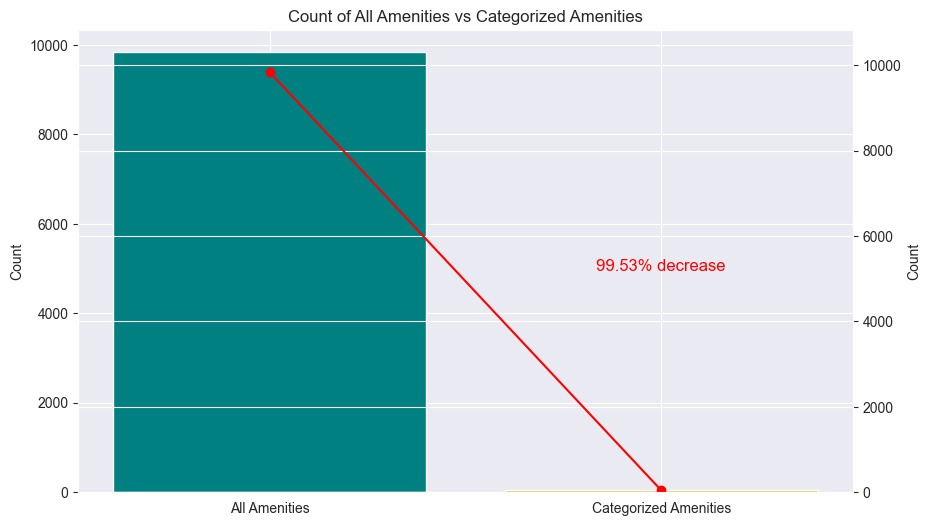

In [58]:
# Calculate the lengths
len_unique_updated_amenities = len(unique_updated_amenities)
len_unique_items = len(unique_items)

# Calculate the percentage decrease
percentage_decrease = ((len_unique_items - len_unique_updated_amenities) / len_unique_items) * 100

# Create a bar plot
labels = ['All Amenities', 'Categorized Amenities']
lengths = [len_unique_items, len_unique_updated_amenities]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bar chart
bars = ax1.bar(labels, lengths, color=['teal', 'orange'])

# Plot line chart
ax2 = ax1.twinx()
ax2.plot(labels, lengths, color='red', marker='o', linestyle='-')
ax2.set_ylim(0, max(lengths) * 1.1)

# Annotate percentage decrease
ax1.text(1, len_unique_updated_amenities + (len_unique_items - len_unique_updated_amenities) / 2,
         f'{percentage_decrease:.2f}% decrease',
         horizontalalignment='center', color='red', fontsize=12)

# Add labels and title
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')
plt.title('Count of All Amenities vs Categorized Amenities')

# Show the plot
plt.show()

Now, we will replace the values in the amenities column. If items outside of the list come up, leave them as they are.

In [59]:
# Correctly rename items in the 'amenities' column
data_train['renamed_amenities'] = data_train['amenities'].apply(lambda x: rename_amenities_list(safe_eval(x), keywords_patterns) if isinstance(x, str) else [])

In [60]:
# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_updated_amenities:
    column_name = item + "_amenity"
    data_train[column_name] = data_train['renamed_amenities'].apply(lambda x: item in x)

# Drop the original amenities and renamed_amenities columns
data_train.drop(['amenities', 'renamed_amenities'], axis=1, inplace=True)

##### Sentiment Analysis of Title, Description and Reviews

In [61]:
# Need to download once for sentiment analysis
# nltk.download('vader_lexicon')

#creating an object of sentiment intensity analyzer
sia= SentimentIntensityAnalyzer()

# creating new columns using polarity scores function
data_train['title_scores'] = data_train['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_train['title_sentiment']=data_train['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_train.drop(['title', 'title_scores'], axis=1, inplace=True)


# creating new columns using polarity scores function
data_train['description_scores']=data_train['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_train['description_sentiment']=data_train['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_train.drop(['description', 'description_scores'], axis=1, inplace=True)

In [62]:
data_train.head()

id  host_response_rate  host_acceptance_rate  \
1507             32155441               100.0                  98.0   
38326            15481083               100.0                 100.0   
3928   675380962217924551               100.0                 100.0   
31420  905087995872873788               100.0                  39.0   
25697            50797136               100.0                 100.0   

       host_is_superhost  host_identity_verified  \
1507                True                    True   
38326               True                    True   
3928               False                    True   
31420              False                    True   
25697               True                   False   

                      neighbourhood   latitude   longitude  \
1507          Le Plateau-Mont-Royal  45.513450  -73.571534   
38326                     Kitsilano  49.262440 -123.151480   
3928                    Ville-Marie  45.494610  -73.572460   
31420            Caledonia-Fairbank  43.685536  -79.447935   
25697  Runnymede-Bloor West Village  43.658910  -79.486310   

            property_type        room_type  ...  sound_system_amenity  \
1507   Entire rental unit  Entire home/apt  ...                 False   
38326  Entire rental unit  Entire home/apt  ...                 False   
3928         Entire condo  Entire home/apt  ...                 False   
31420         Entire home  Entire home/apt  ...                 False   
25697  Entire rental unit  Entire home/apt  ...                 False   

       sports_amenity  AC_amenity  netflix_amenity  wifi_amenity  \
1507            False        True            False          True   
38326           False        True            False          True   
3928            False        True            False          True   
31420           False        True            False          True   
25697           False        True            False          True   

       cleaning products_amenity  utensils_amenity  grill_amenity  \
1507                        True              True          False   
38326                      False              True          False   
3928                        True              True          False   
31420                       True              True           True   
25697                       True              True          False   

       title_sentiment  description_sentiment  
1507           -0.2960                 0.9812  
38326           0.0000                 0.2732  
3928            0.0000                 0.9837  
31420           0.5411                 0.0000  
25697           0.0000                 0.3818  

[5 rows x 188 columns]

#### Feature Selection

In [63]:
train_features = data_train.drop(['id', 'neighbourhood'], axis=1)

In [64]:
for col in train_features.columns[train_features.isnull().any()]:
    print(col)
else:
    print("No null values!")

No null values!


In [65]:
list(train_features.columns.values)

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_identity_verified',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'review_scores_rating',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value_for_money',
 'license',
 'instant_bookable',
 'city',
 'review_sentiment_score',
 'host_since_days',
 'distance_to_downtown',
 'nearby_attractions',
 'host_response_time_encoded',
 'property_Barn',
 'property_Boat',
 'property_Bus',
 'property_Camper/RV',
 'property_Campsite',
 'property_Casa particular',
 'property_Castle',
 'property_Cave',
 'property_Dome',
 'property_Earthen home',
 'property_Entire bed and breakfast',
 'property_Entire bungalow',
 'property_Entire cabin

#### Replicating all the adjustments we have made to testing dataset

Data Preprocessing

In [66]:
# Converting values in price column to its natural logarithm
data_test['price'] = np.log(data_test['price'])

In [67]:
# Fill null value with unlicensed
data_test['license'].fillna('Unlicensed', inplace=True)

# Drop rows with empty price
data_test = data_test.dropna(subset=['price'])

data_test = data_test.dropna(subset=['review_scores_rating'])
data_test = data_test.dropna(subset=['review_sentiment_score'])

# Fill null in host realted columns
data_test['host_is_superhost'] = data_test['host_is_superhost'].fillna('f')
data_test['has_availability'] = data_test['has_availability'].fillna('f')
data_test['host_response_time'] = data_test['host_response_time'].fillna(data_test['host_response_time'].mode()[0])

# Remove % sign and convert to numeric for the following columns
data_test['host_response_rate'] = pd.to_numeric(data_test['host_response_rate'].str.replace('%', ''))
data_test['host_acceptance_rate'] = pd.to_numeric(data_test['host_acceptance_rate'].str.replace('%', ''))

# Fill null values in specified columns with median values
for column in numeric_columns:
    median_value = data_test[column].median()
    data_test[column].fillna(median_value, inplace=True)

In [68]:
# Rechecking null values
data_test.isnull().sum().sort_values(ascending=False)

id                               0
title                            0
maximum_nights                   0
has_availability                 0
availability_30                  0
availability_60                  0
availability_90                  0
availability_365                 0
first_review_date                0
last_review_date                 0
review_scores_rating             0
review_scores_cleanliness        0
review_scores_checkin            0
review_scores_communication      0
review_scores_location           0
review_scores_value_for_money    0
license                          0
instant_bookable                 0
city                             0
minimum_nights                   0
price                            0
amenities                        0
host_identity_verified           0
description                      0
host_since                       0
host_response_time               0
host_response_rate               0
host_acceptance_rate             0
host_is_superhost   

Feature Extraction

In [69]:
# Adding days since columns
# Converting date columns
data_test['host_since'] = pd.to_datetime(data_test['host_since'])

# Calculating values and storing in a new column
data_test['host_since_days'] = (current_date - data_test['host_since']).dt.days

# Dropping date columns
data_test.drop(columns=['host_since', 'first_review_date', 'last_review_date'], inplace=True)

In [70]:
# Distance to downtown

# Calculate distance to downtown using broadcasting
for city, (lat, lon) in downtown_coords.items():
    mask = data_test['city'] == city
    data_test.loc[mask, 'distance_to_downtown'] = haversine_distance(
        data_test.loc[mask, 'latitude'].values, 
        data_test.loc[mask, 'longitude'].values, 
        lat, 
        lon
    )

In [71]:
# Number of attractions

# Calculate attractions within 10km for each Airbnb listing
attraction_counts = []
for city in data_test['city'].unique():
    attractions_city = attractions_df[attractions_df['city'] == city]
    if not attractions_city.empty:
        attraction_counts.extend(data_test[data_test['city'] == city].apply(
            lambda row: count_attractions_within_radius(row['latitude'], row['longitude'], attractions_city),
            axis=1
        ))
    else:
        attraction_counts.extend([0] * len(data_test[data_test['city'] == city]))

data_test['nearby_attractions'] = attraction_counts

Data Encoding

In [72]:
# Converting boolean columns and picture url columns to 0s and 1s
for boolean_column in ['host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable']:
    data_test[boolean_column] = data_test[boolean_column].map(lambda s: False if s == "f" else True)

In [73]:
# Changing data in license column to licensed and unlicensed and converting to boolean
data_test['license'] = data_test['license'].map(lambda s: False if s == "Unlicensed" else True)

# Ordinal Encoding host_response_time since there is a clear order
data_test['host_response_time_encoded'] = ordinal_encoder.fit_transform(data_test[['host_response_time']])
data_test.drop(columns=['host_response_time'], inplace=True)

In [74]:
# Create the dummy variables without dropping the original column
dummy_vars = pd.get_dummies(data_test['property_type'], prefix='property')
# Concatenate the original DataFrame with the dummy variables
data_test = pd.concat([data_test, dummy_vars], axis=1)
# Create the dummy variables without dropping the original column
dummy_vars = pd.get_dummies(data_test['city'], prefix='city')
# Concatenate the original DataFrame with the dummy variables
data_test = pd.concat([data_test, dummy_vars], axis=1)
# Create the dummy variables without dropping the original column
dummy_vars = pd.get_dummies(data_test['room_type'], prefix='room_type')
# Concatenate the original DataFrame with the dummy variables
data_test = pd.concat([data_test, dummy_vars], axis=1)

In [75]:
# One hot encoding verifications

# Extract unique items from the list in the column
unique_items = set(item for sublist in data_test['host_verifications'].apply(safe_eval) for item in sublist)

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_items:
    column_name = item + "_verification"
    data_test[column_name] = data_test['host_verifications'].apply(lambda x: True if item in x else False)

# Drop the original amenities column
data_test.drop('host_verifications', axis=1, inplace=True)

In [76]:
# Amenities

# Flatten the lists and extract unique items
unique_items = set(item for sublist in data_test['amenities'].apply(safe_eval) for item in sublist if item)

# Filter out any empty strings from unique_amenities
filtered_unique_amenities = [amenity for amenity in unique_items if amenity.strip()]

# Apply the function to rename items in the filtered 'unique_amenities' list using list comprehension
updated_amenities = [rename_item(amenity, keywords_patterns) for amenity in filtered_unique_amenities]

# Remove items that did not match any keyword pattern
updated_amenities = [amenity for amenity in updated_amenities if amenity is not None]

# Extract unique items from the list in the column
unique_updated_amenities = list(set(updated_amenities))

# Correctly rename items in the 'amenities' column
data_test['renamed_amenities'] = data_test['amenities'].apply(lambda x: rename_amenities_list(safe_eval(x), keywords_patterns) if isinstance(x, str) else [])

# Apply one hot encoding to the unique_items and create a new column for each item
for item in unique_updated_amenities:
    column_name = item + "_amenity"
    data_test[column_name] = data_test['renamed_amenities'].apply(lambda x: item in x)

# Drop the original amenities and renamed_amenities columns
data_test.drop(['amenities', 'renamed_amenities'], axis=1, inplace=True)

In [77]:
# Sentiment Scores

# creating new columns using polarity scores function
data_test['title_scores'] = data_test['title'].apply(lambda title: sia.polarity_scores(str(title)))
data_test['title_sentiment']=data_test['title_scores'].apply(lambda score_dict:score_dict['compound'])
data_test.drop(['title', 'title_scores'], axis=1, inplace=True)

# creating new columns using polarity scores function
data_test['description_scores']=data_test['description'].apply(lambda description: sia.polarity_scores(str(description)))
data_test['description_sentiment']=data_test['description_scores'].apply(lambda score_dict:score_dict['compound'])
data_test.drop(['description', 'description_scores'], axis=1, inplace=True)

Feature Selection

In [78]:
test_features = data_test.drop(['id', 'neighbourhood'], axis=1)

for col in test_features.columns[test_features.isnull().any()]:
    print(col)
else:
    print("No null values!")

No null values!


In [79]:
test_features.head()

host_response_rate  host_acceptance_rate  host_is_superhost  \
49141               100.0                  62.0               True   
13126               100.0                  98.0              False   
9317                100.0                 100.0               True   
21994               100.0                  98.0              False   
25393               100.0                 100.0              False   

       host_identity_verified   latitude  longitude  \
49141                    True  49.862583 -97.196664   
13126                    True  45.277470 -75.842150   
9317                     True  46.606490 -65.728670   
21994                    True  43.651820 -79.480460   
25393                    True  43.673420 -79.330130   

                     property_type        room_type  accommodates  bathrooms  \
49141                  Entire home  Entire home/apt             6        1.0   
13126  Private room in guest suite     Private room             1        1.0   
9317                  Entire cabin  Entire home/apt             8        1.0   
21994         Private room in home     Private room             3        1.0   
25393                  Entire home  Entire home/apt             6        1.5   

       ...  sound_system_amenity  AC_amenity  sports_amenity  netflix_amenity  \
49141  ...                 False        True           False            False   
13126  ...                 False        True           False            False   
9317   ...                 False        True           False            False   
21994  ...                 False        True           False            False   
25393  ...                  True        True           False            False   

       wifi_amenity  cleaning products_amenity  utensils_amenity  \
49141          True                       True              True   
13126          True                      False              True   
9317           True                       True              True   
21994          True                      False              True   
25393          True                       True              True   

       grill_amenity  title_sentiment  description_sentiment  
49141          False           0.0000                 0.9441  
13126          False           0.5106                 0.7177  
9317            True           0.2714                 0.9824  
21994          False           0.0000                 0.6361  
25393           True           0.0000                 0.9032  

[5 rows x 124 columns]

### Data Preparation

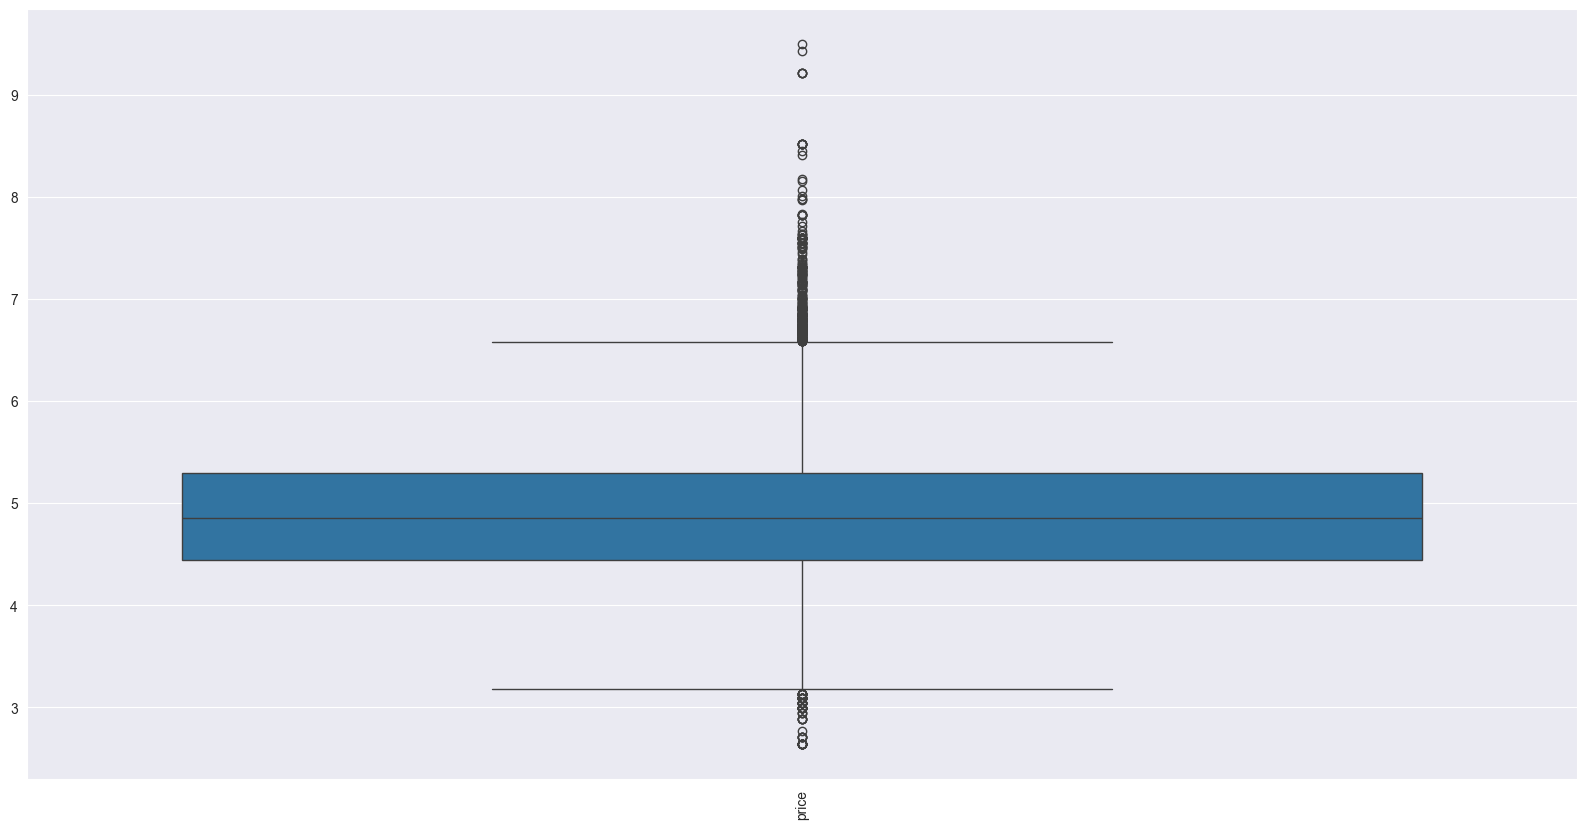

In [80]:
# Checking for outliers in price
plt.figure(figsize=(20,10))
sns.boxplot(data=train_features[['price']])
plt.xticks(rotation=90)
plt.show()

Removing or not removing the outliers doesn't change the output much, meaning the models are well equipped to handle outliners

In [81]:
# #Handling Outliers using median and IQR 
# def outlier(a):
#     Q1 = a.quantile(0.25)
#     Q3 = a.quantile(0.75)
#     IQR = Q3-Q1
#     L = Q1 - 1.5*IQR
#     U = Q3 + 1.5*IQR
#     return(L,U)
# 
# # Updating price
# train_features = train_features.loc[train_features['price'] >= outlier(train_features['price'])[0]]
# train_features = train_features.loc[train_features['price'] <= outlier(train_features['price'])[1]]
# 
# # Visualize change
# plt.figure(figsize=(5,5))
# sns.boxplot(data=train_features[['price']])
# plt.xticks(rotation=90)
# plt.show()

#### Feature and Target selection for different models

In [82]:
# Drop encoded columns for LightGBM
# Identify columns to drop
cols_to_drop = train_features.filter(regex='^(property_(?!type$)|city_|room_type_)').columns

# Drop the identified columns
# These are our training features for the final model
X_train_selected = train_features.drop(columns=cols_to_drop)
X_train_selected = X_train_selected.drop(['price'], axis=1)
# Identify columns to drop
# THese are our testing features for the final model
cols_to_drop = test_features.filter(regex='^(property_(?!type$)|city_|room_type_)').columns
X_test_selected = test_features.drop(columns=cols_to_drop)
X_test_selected = X_test_selected.drop(['price'], axis=1)

# Drop categorical columns for other models
X_train = train_features.drop(columns=['price', 'property_type', 'city', 'room_type'])
X_test = test_features.drop(columns=['price', 'property_type', 'city', 'room_type'])

# Aligning column discrepancy due to separating property types. Important step.
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

# Selecting target for train and test
y_train = train_features['price']
y_test = test_features['price']

X_train_selected.shape, X_test_selected.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30499, 84), (291, 84), (30499, 120), (291, 120), (30499,), (291,))

## Model Building

Linear Regerssion

In [83]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

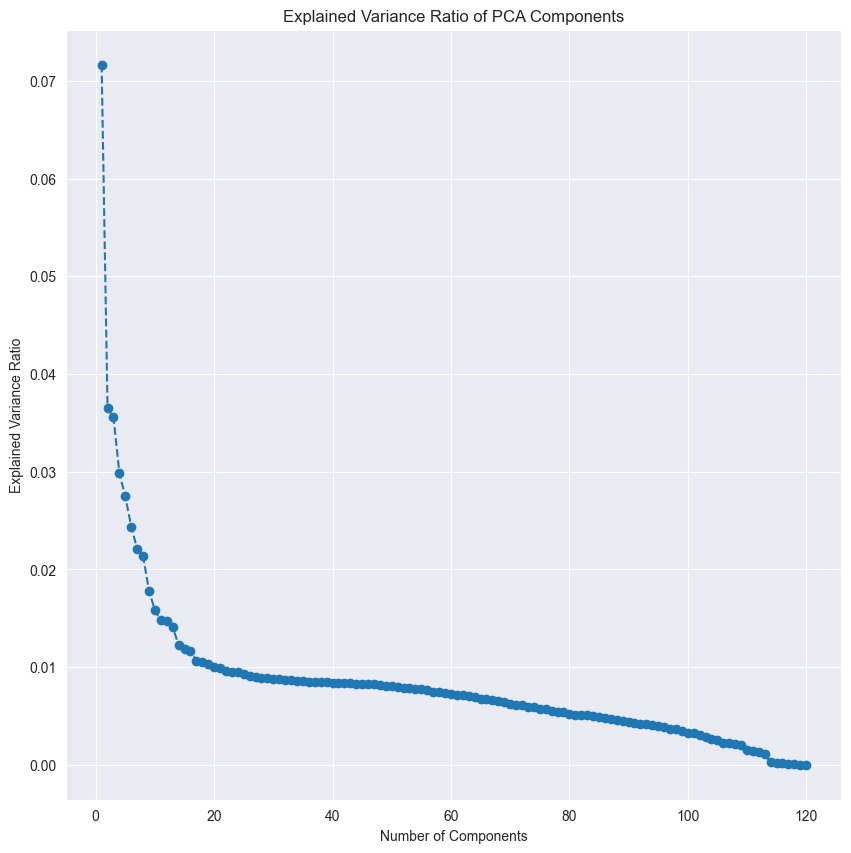

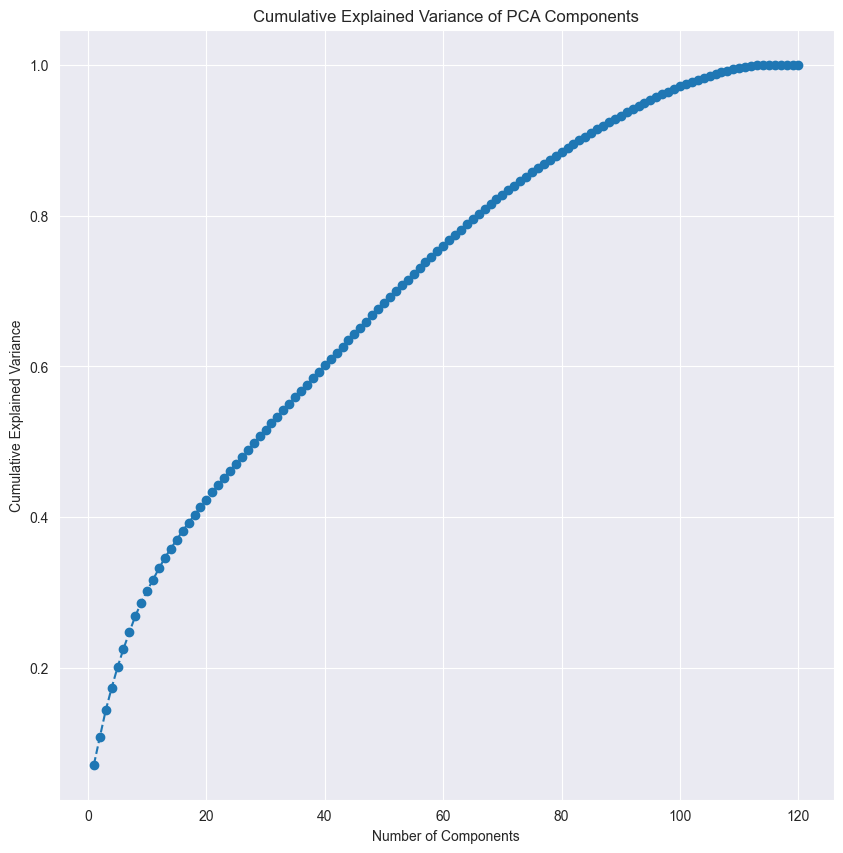

Cumulative Explained Variance Ratio:
Components: 1, Cumulative Explained Variance: 0.0717
Components: 2, Cumulative Explained Variance: 0.1081
Components: 3, Cumulative Explained Variance: 0.1437
Components: 4, Cumulative Explained Variance: 0.1736
Components: 5, Cumulative Explained Variance: 0.2010
Components: 6, Cumulative Explained Variance: 0.2254
Components: 7, Cumulative Explained Variance: 0.2475
Components: 8, Cumulative Explained Variance: 0.2689
Components: 9, Cumulative Explained Variance: 0.2867
Components: 10, Cumulative Explained Variance: 0.3025
Components: 11, Cumulative Explained Variance: 0.3173
Components: 12, Cumulative Explained Variance: 0.3320
Components: 13, Cumulative Explained Variance: 0.3461
Components: 14, Cumulative Explained Variance: 0.3584
Components: 15, Cumulative Explained Variance: 0.3702
Components: 16, Cumulative Explained Variance: 0.3818
Components: 17, Cumulative Explained Variance: 0.3925
Components: 18, Cumulative Explained Variance: 0.4030


In [84]:
# Initialize PCA
pca = PCA()

# Fit PCA on the scaled features
pca.fit(X_train_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 10))
plt.plot(range(1, X_train_scaled.shape[1] + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of PCA Components')
plt.grid(True)
plt.show()

# Plot cumulative explained variance ratio
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 10))
plt.plot(range(1, X_train_scaled.shape[1] + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance of PCA Components')
plt.grid(True)
plt.show()

# Print the cumulative explained variance ratio
print("Cumulative Explained Variance Ratio:")
for i, variance in enumerate(cumulative_variance):
    print(f"Components: {i + 1}, Cumulative Explained Variance: {variance:.4f}")

Reducing Dimensionality with PCA

In [85]:
# Initialize PCA with desired number of components
pca = PCA(n_components=98) # Using Cumulative Explained Variance of 95%

# Fit PCA and transform the features
train_pca = pca.fit_transform(X_train_scaled)
test_pca = pca.transform(X_test_scaled)

Building and evaluating linear regression model

In [86]:
# Building and evaluating the model
model_linear = LinearRegression()
model_linear.fit(train_pca, y_train)
# Predicting the price
train_pred_linear = model_linear.predict(train_pca)
test_pred_linear = model_linear.predict(test_pca)

# Evaluate Linear Regression
l_train_r2 = r2_score(y_train, train_pred_linear)
l_train_mse = mean_squared_error(y_train, train_pred_linear)
l_test_r2 = r2_score(y_test, test_pred_linear)
l_test_mse = mean_squared_error(y_test, test_pred_linear)

# Calculating and printing the evaluation metrices values
print(f'\n--------Linear Regression Train Fitting-----------')
print(f'R2 Score: {l_train_r2}')
print(f'MSE: {l_train_mse}')

print(f'--------Linear Regression Test Fitting-----------')
print(f'R2 Score: {l_test_r2}')
print(f'MSE: {l_test_mse}')


--------Linear Regression Train Fitting-----------
R2 Score: 0.6321740202486203
MSE: 0.1709517367135655
--------Linear Regression Test Fitting-----------
R2 Score: 0.6243788673013462
MSE: 0.1783631308895281


##### Ridge

Identifying ideal hyperparameter value

In [87]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Expand the range of alphas
alphas = logspace(-3, 2, 50)

# Initialize the model with expanded alphas range
model = RidgeCV(alphas=alphas, cv=cv, scoring='neg_mean_absolute_error')
# Training the model
model.fit(X_train_scaled, y_train)

# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.138950


Building and evaluating ridge model

In [88]:
# Ridge Regression
model_ridge = Ridge(alpha=0.13, random_state=42) # Used RidgeCV to identify ideal hyperparameter
model_ridge.fit(X_train, y_train)

# Predicting the price
train_pred_ridge = model_ridge.predict(X_train)
test_pred_ridge = model_ridge.predict(X_test)

# Evaluate Ridge Regression
r_train_r2 = r2_score(y_train, train_pred_ridge)
r_train_mse = mean_squared_error(y_train, train_pred_ridge)
r_test_r2 = r2_score(y_test, test_pred_ridge)
r_test_mse = mean_squared_error(y_test, test_pred_ridge)

# Printing the evaluation metrices values
print(f'\n--------Ridge Regression Train Fitting-----------')
print(f'R2 Score: {r_train_r2}')
print(f'MSE: {r_train_mse}')
print(f'--------Ridge Regression Test Fitting-----------')
print(f'R2 Score: {r_test_r2}')
print(f'MSE: {r_test_mse}')


--------Ridge Regression Train Fitting-----------
R2 Score: 0.6447024446739418
MSE: 0.16512899435251474
--------Ridge Regression Test Fitting-----------
R2 Score: 0.6368296188772998
MSE: 0.17245091019773745


##### Light GBM

Determining appropriate parameter grid

In [89]:
# # Define the parameter grid to test
# param_grid = {
#     'num_leaves': [31, 50, 100, 200],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 500, 1000, 3000]
# }
# 
# # Initialize the model
# model_lgbm = lgb.LGBMRegressor()
# 
# # Grid search
# grid_search = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train_scaled, y_train)
# 
# # Best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# 
# print(f"Best Parameters: {best_params}")
# print(f"Best Score: {best_score}")

Commented out because the process takes too long.
Output was the following:

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 3000, 'num_leaves': 200}
Best Score: -0.08903935863242121

In [90]:
# Build the model
final_model_lgbm = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=3000, num_leaves=200, verbose=0, max_depth=-1, random_state=42)

In [91]:
final_model_lgbm.fit(X_train, y_train)

test_pred_flgbm = final_model_lgbm.predict(X_test)
train_pred_flgbm = final_model_lgbm.predict(X_train)

# Evaluate Light GBM
flgbm_train_r2 = r2_score(y_train, train_pred_flgbm)
flgbm_train_mse = mean_squared_error(y_train, train_pred_flgbm)
flgbm_test_r2 = r2_score(y_test, test_pred_flgbm)
flgbm_test_mse = mean_squared_error(y_test, test_pred_flgbm)

# Printing the evaluation metrices values
print(f'\n--------Light GBM Train Fitting-----------')
print(f'R2 Score: {flgbm_train_r2}')
print(f'MSE: {flgbm_train_mse}')
print(f'--------Light GBM Test Fitting-----------')
print(f'R2 Score: {flgbm_test_r2}')
print(f'MSE: {flgbm_test_mse}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

--------Light GBM Train Fitting-----------
R2 Score: 0.9831954162397953
MSE: 0.007810141035979372
--------Light GBM Test Fitting-----------
R2 Score: 0.78240185231123
MSE: 0.10332615371954561


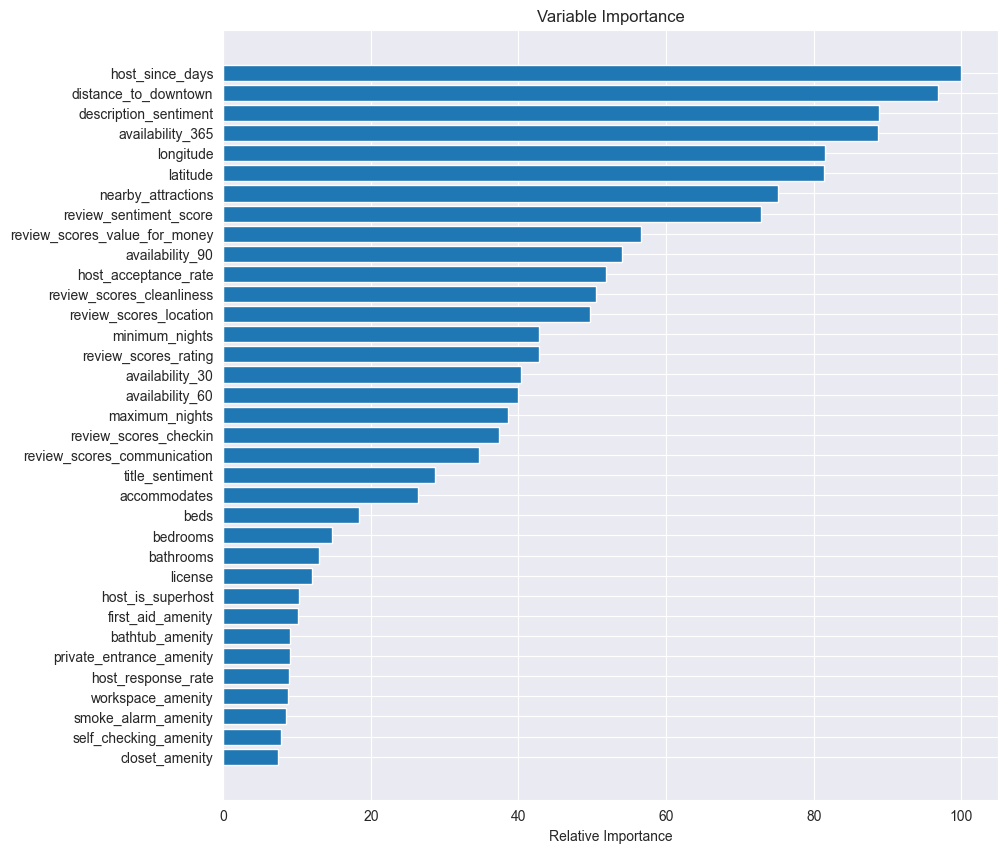

In [92]:
# Plot feature importance
top = 35
feature_importance = final_model_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (10,10))
plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
plt.yticks(pos[-top:], X_train.columns[sorted_idx][-top:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

##### XG Boost

In [93]:
model_xgb = xgb.XGBRegressor(learning_rate=0.04, max_depth=10, min_child_weight=2, n_estimators=1500, seed=25)
model_xgb.fit(X_train, y_train)

train_pred_xgb = model_xgb.predict(X_train)
test_pred_xgb = model_xgb.predict(X_test)

# Evaluate Light GBM
xgb_train_r2 = r2_score(y_train, train_pred_xgb)
xgb_train_mse = mean_squared_error(y_train, train_pred_xgb)
xgb_test_r2 = r2_score(y_test, test_pred_xgb)
xgb_test_mse = mean_squared_error(y_test, test_pred_xgb)

# Printing the evaluation metrices values
print(f'\n--------XG Boost Train Fitting-----------')
print(f'R2 Score: {xgb_train_r2}')
print(f'MSE: {xgb_train_mse}')
print(f'--------XG Boost Test Fitting-----------')
print(f'R2 Score: {xgb_test_r2}')
print(f'MSE: {xgb_test_mse}')


--------XG Boost Train Fitting-----------
R2 Score: 0.999457781419152
MSE: 0.00025200288499737934
--------XG Boost Test Fitting-----------
R2 Score: 0.7781633167128501
MSE: 0.1053388159845313


##### Random Forest Regressor

In [94]:
#Train the model again since less important features were removed
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

train_pred_rf = model_rf.predict(X_train)
test_pred_rf = model_rf.predict(X_test)

# Evaluate Light GBM
rf_train_r2 = r2_score(y_train, train_pred_rf)
rf_train_mse = mean_squared_error(y_train, train_pred_rf)
rf_test_r2 = r2_score(y_test, test_pred_rf)
rf_test_mse = mean_squared_error(y_test, test_pred_rf)

# Printing the evaluation metrices values
print(f'\n--------Random Forest Train Fitting-----------')
print(f'R2 Score: {rf_train_r2}')
print(f'MSE: {rf_train_mse}')
print(f'--------Random Forest Test Fitting-----------')
print(f'R2 Score: {rf_test_r2}')
print(f'MSE: {rf_test_mse}')


--------Random Forest Train Fitting-----------
R2 Score: 0.9632543965468627
MSE: 0.01707798000333676
--------Random Forest Test Fitting-----------
R2 Score: 0.7615793683639756
MSE: 0.11321367895819832


#### Comparing the performance of different models

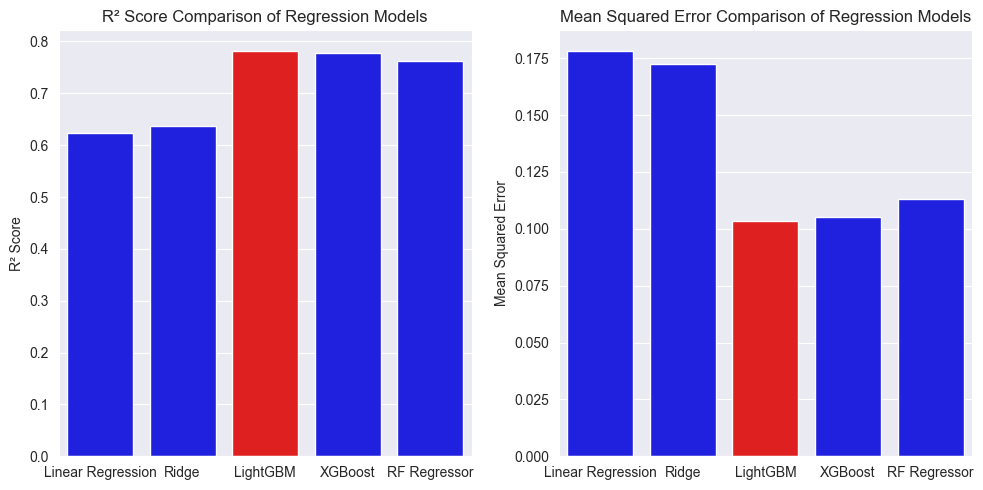

R² Scores:
               Model  R² Score
0  Linear Regression  0.624379
1              Ridge  0.636830
2           LightGBM  0.782402
3            XGBoost  0.778163
4       RF Regressor  0.761579

Mean Squared Errors:
               Model       MSE
0  Linear Regression  0.178363
1              Ridge  0.172451
2           LightGBM  0.103326
3            XGBoost  0.105339
4       RF Regressor  0.113214


In [95]:
# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'LightGBM', 'XGBoost', 'RF Regressor'],
    'R² Score': [l_test_r2, r_test_r2, flgbm_test_r2, xgb_test_r2, rf_test_r2],
    'MSE': [l_test_mse, r_test_mse, flgbm_test_mse, xgb_test_mse, rf_test_mse]
})

# Find the index of the highest R² score and lowest MSE
best_r2_idx = results_df['R² Score'].idxmax()
best_mse_idx = results_df['MSE'].idxmin()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot R² scores with custom colors
palette_r2 = ['red' if i == best_r2_idx else 'blue' for i in range(len(results_df))]
sns.barplot(ax=axes[0], x='Model', y='R² Score', data=results_df, palette=palette_r2)
axes[0].set_title('R² Score Comparison of Regression Models')
axes[0].set_xlabel('')
axes[0].set_ylabel('R² Score')

# Plot MSE with custom colors
palette_mse = ['red' if i == best_mse_idx else 'blue' for i in range(len(results_df))]
sns.barplot(ax=axes[1], x='Model', y='MSE', data=results_df, palette=palette_mse)
axes[1].set_title('Mean Squared Error Comparison of Regression Models')
axes[1].set_xlabel('')
axes[1].set_ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

# Print the results for quick reference
print("R² Scores:")
print(results_df[['Model', 'R² Score']])

print("\nMean Squared Errors:")
print(results_df[['Model', 'MSE']])

#### Insights

Visualizing importance of added features

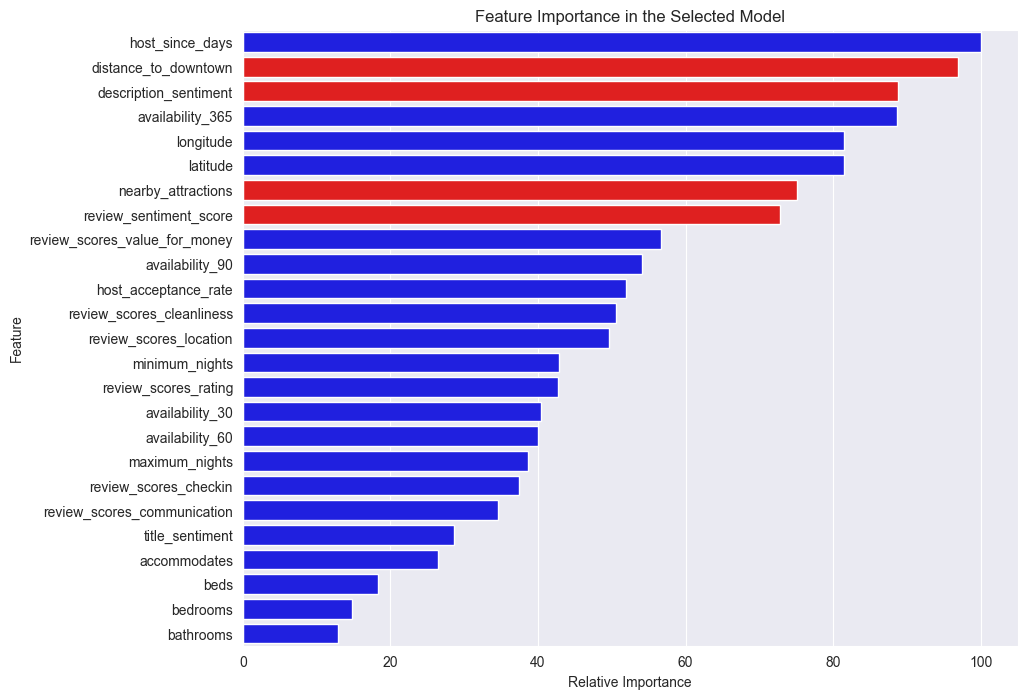

In [96]:
# Highlight specific features
highlight_features = ['distance_to_downtown', 'nearby_attractions', 'description_sentiment', 'review_sentiment_score']

# Show top 25 features
top = 25

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Assign colors based on highlight
feature_importance_df['Color'] = feature_importance_df['Feature'].apply(lambda x: 'red' if x in highlight_features else 'blue')

# Plot the graph
plt.figure(figsize = (10,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25), palette=feature_importance_df['Color'].head(25).values)
plt.xlabel('Relative Importance')
plt.title('Feature Importance in the Selected Model')
plt.show()

Importance of proximity to attractions

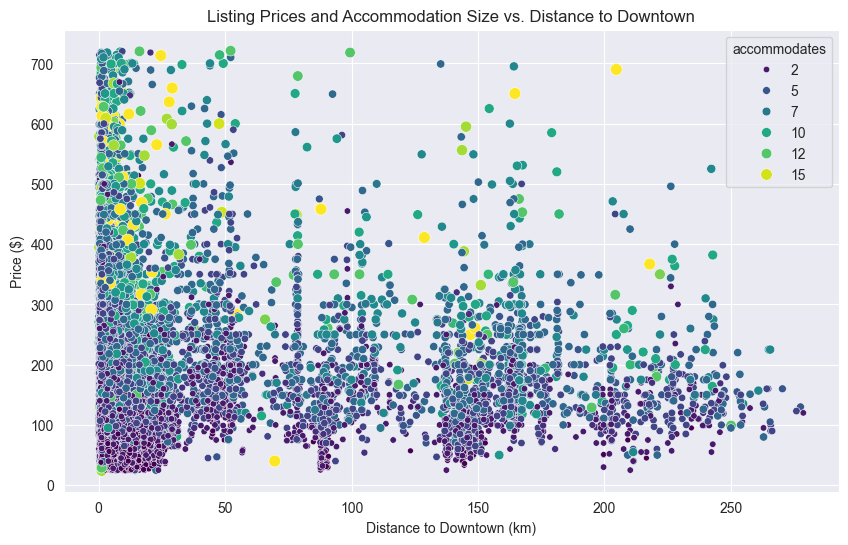

In [97]:
#Merge train and test data
combined_features = pd.concat([train_features, test_features], axis=0, ignore_index=True)

# Remove price outliers
def outlier(a):
    Q1 = a.quantile(0.25)
    Q3 = a.quantile(0.75)
    IQR = Q3-Q1
    L = Q1 - 1.5*IQR
    U = Q3 + 1.5*IQR
    return(L,U)

# Updating price
combined_features = combined_features.loc[combined_features['price'] >= outlier(combined_features['price'])[0]]
combined_features = combined_features.loc[combined_features['price'] <= outlier(combined_features['price'])[1]]

# Convert price back to normal
combined_features['price'] = np.exp(combined_features['price'])

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_features, x='distance_to_downtown', y='price', hue='accommodates', size='accommodates', palette='viridis')
plt.title('Listing Prices and Accommodation Size vs. Distance to Downtown')
plt.xlabel('Distance to Downtown (km)')
plt.ylabel('Price ($)')
plt.show()

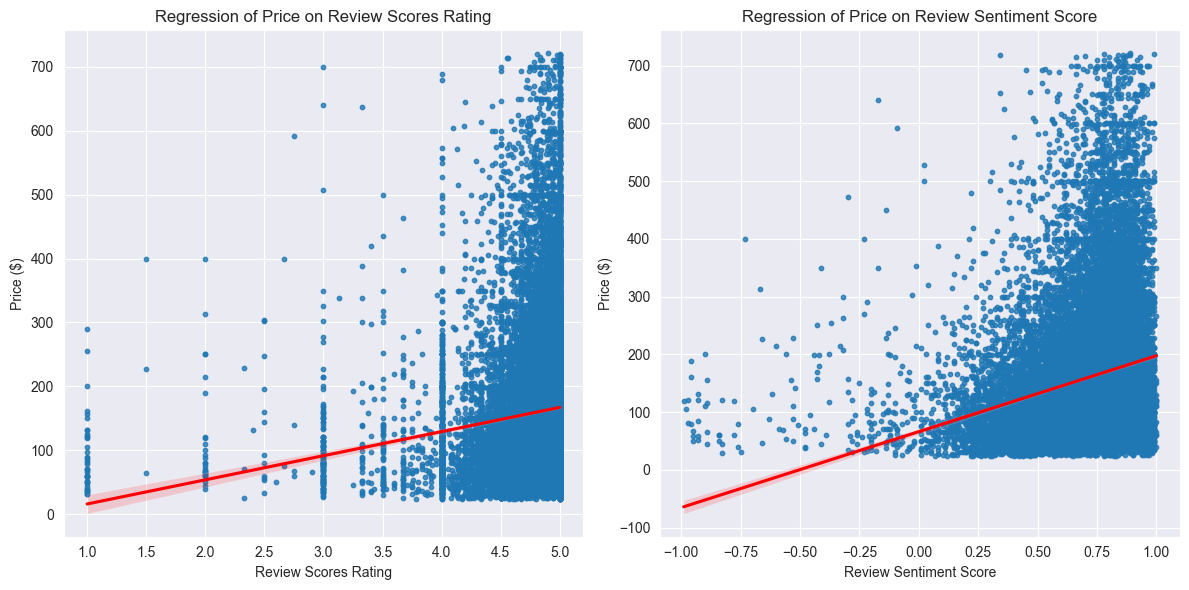

In [98]:
# # Filter for distance_to_downtown <= 100 km
# combined_features = combined_features[combined_features['review_scores_rating'] > 0]
combined_features = combined_features[combined_features['review_sentiment_score'] != 0]

# Regression Plot for review_scores_rating vs. price
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.regplot(data=combined_features, x='review_scores_rating', y='price', scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Regression of Price on Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price ($)')

# Regression Plot for review_sentiment_score vs. price
plt.subplot(1, 2, 2)
sns.regplot(data=combined_features, x='review_sentiment_score', y='price', scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Regression of Price on Review Sentiment Score')
plt.xlabel('Review Sentiment Score')
plt.ylabel('Price ($)')

plt.tight_layout()
plt.show()

In [99]:
# Fill null value with unlicensed
calculation_df = airbnb_df.copy()
# Changing license data
calculation_df['license'] = airbnb_df['license'].map(lambda s: "Unlicensed" if pd.isnull(s) else "Licensed")
# Changing room_type data
calculation_df['residence'] = airbnb_df['room_type'].map(lambda s: "Not Principal" if s == "Entire home/apt" else "Principal")
calculation_df['term'] = airbnb_df['minimum_nights'].map(lambda s: "Long Term" if s >= 28 else "Short Term")

# Group by license and room_type, then count the number of listings
license_room_type_counts = calculation_df.groupby(['license', 'residence', 'term']).size().reset_index(name='count')

# Display the grouped data
print(license_room_type_counts)

      license      residence        term  count
0    Licensed  Not Principal   Long Term   3663
1    Licensed  Not Principal  Short Term  12212
2    Licensed      Principal   Long Term   1512
3    Licensed      Principal  Short Term   4637
4  Unlicensed  Not Principal   Long Term  13748
5  Unlicensed  Not Principal  Short Term   6837
6  Unlicensed      Principal   Long Term   5307
7  Unlicensed      Principal  Short Term   1720


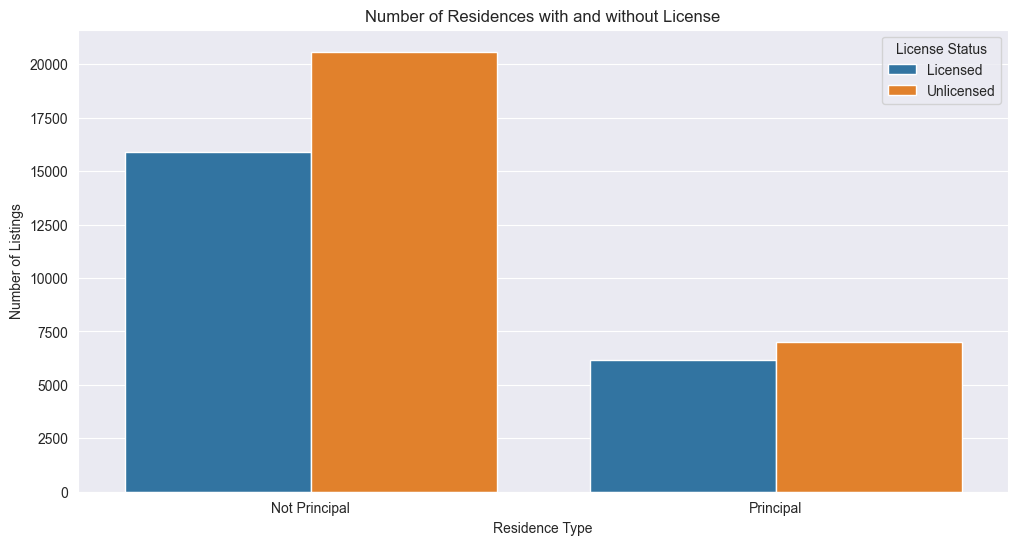

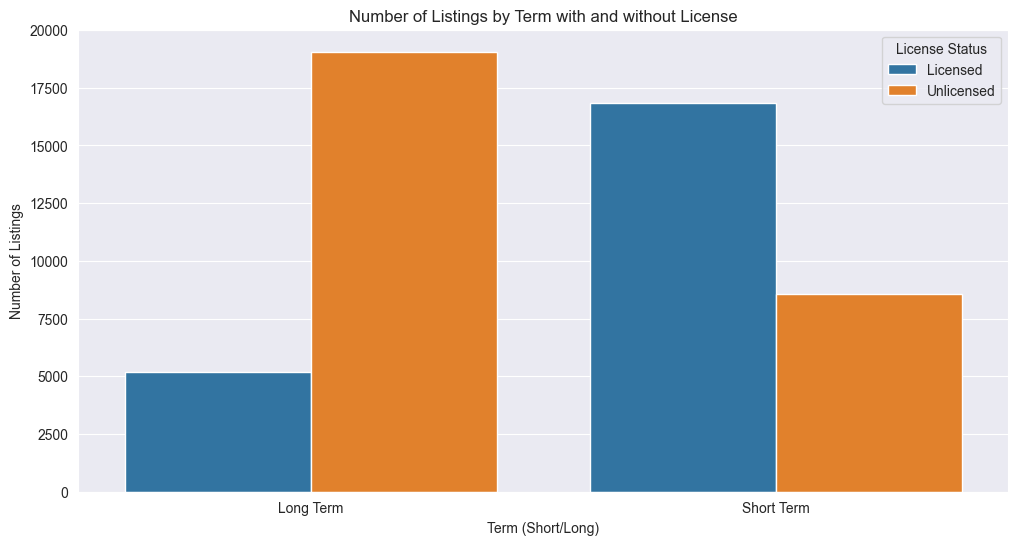

In [100]:
# Group by license and residence, then sum the counts
residence_license_counts = calculation_df.groupby(['license', 'residence']).size().reset_index(name='count')

# Create a bar plot for residence type vs. license status
plt.figure(figsize=(12, 6))
sns.barplot(data=residence_license_counts, x='residence', y='count', hue='license')
plt.title('Number of Residences with and without License')
plt.xlabel('Residence Type')
plt.ylabel('Number of Listings')
plt.legend(title='License Status')
plt.show()

# Group by license and term, then sum the counts
term_license_counts = calculation_df.groupby(['license', 'term']).size().reset_index(name='count')

# Create a bar plot for term vs. license status
plt.figure(figsize=(12, 6))
sns.barplot(data=term_license_counts, x='term', y='count', hue='license')
plt.title('Number of Listings by Term with and without License')
plt.xlabel('Term (Short/Long)')
plt.ylabel('Number of Listings')
plt.legend(title='License Status')
plt.show()

According to the law across all 8 cities in Canada, all short term-rentals (renting less than 28 days) and primary residence rentals require a license to operate and host guests in online platforms. But, have they all been operating legally?

In [101]:
# Total listings count
total_listings = airbnb_df.shape[0]

# Filter for "Principal" residences that are "Unlicensed"
principal_unlicensed = calculation_df[(calculation_df['residence'] == 'Principal') & (calculation_df['license'] == 'Unlicensed')]

# Sum the counts for "Principal" unlicensed listings
principal_unlicensed_count = principal_unlicensed.shape[0]

# Filter for "Short Term" term that are "Unlicensed"
short_term_unlicensed = calculation_df[(calculation_df['term'] == 'Short Term') & (calculation_df['license'] == 'Unlicensed')]

# Sum the counts for "Short Term" unlicensed listings
short_term_unlicensed_count = short_term_unlicensed.shape[0]

# Total number of illegal listings
total_illegal_listings = principal_unlicensed_count + short_term_unlicensed_count

print(f"Total number of illegal listings: {total_illegal_listings}")
print(f"Percentage of illegal listings: {round(total_illegal_listings/total_listings*100)}%")

Total number of illegal listings: 15584
Percentage of illegal listings: 31%


## Model Tuning

Identifying the predictions that have the highest residuals.

In [102]:
# Calculate residuals
residuals = test_pred_flgbm - y_test

# Calculate absolute residuals
abs_residuals = np.abs(residuals)

# Create a dataframe with actual, predicted prices, and residuals
results_df = pd.DataFrame({
    'actual_price': y_test,
    'predicted_price': test_pred_flgbm,
    'residual': residuals,
    'absolute_residual': abs_residuals
})

# Add an auto-incrementing index column starting from 0
results_df['row_number'] = range(len(results_df))

# Sort the dataframe by absolute residuals in descending order
sorted_results_df = results_df.sort_values(by='absolute_residual', ascending=False)

print("Top 10 most incorrect predictions:")
sorted_results_df.head(10)

Top 10 most incorrect predictions:


actual_price  predicted_price  residual  absolute_residual  row_number
45995      7.313220         4.891199 -2.422021           2.422021          24
31755      7.170120         5.641372 -1.528748           1.528748         165
23768      4.553877         5.892999  1.339122           1.339122         124
1406       5.874931         4.958903 -0.916027           0.916027         176
13637      4.110874         4.891166  0.780292           0.780292          43
29002      4.488636         5.173929  0.685293           0.685293         285
15686      5.093750         4.411548 -0.682202           0.682202         209
16688      3.663562         4.333327  0.669765           0.669765         106
42596      6.893656         6.234463 -0.659193           0.659193          78
31277      4.804021         5.410630  0.606609           0.606609         288

In [103]:
# Stacking features and target for interpretability
test = [X_test, y_test]

Using SHAP to interpret the model

In [104]:
# Creating a function to calculate SHAP values and display visualization based on provided parameters

def XAI_SHAP(model, data, graph, obs=0):
    """ Computes SHAP values and represents XAI graphs

    - Parameters:
        - model = Machine Learning model to interpret
        - data = Data used to make explanations
        - graph = Global or local interpretation
        - obs = Index of data instance to explain

    - Output:
        - XAI graphs and SHAP values
    """
    # Print JavaScript visualizations
    shap.initjs()

    # Create object to calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(data)
    
    if graph == 'global':
        # Global Interpretability (feature importance)
        shap.plots.bar(shap_values, max_display=20)
        
        # Global Interpretability (impact on target variable)
        shap.summary_plot(shap_values, data, max_display=20)
        
    else:
        # Local Interpretability (coefficients)
        # shap.plots.bar(shap_values[obs], max_display=20)
        shap.plots.waterfall(shap_values[obs], max_display=20)

        # Local Interpretability (force plots)
        # shap.plots.force(shap_values[obs])
    return shap_values

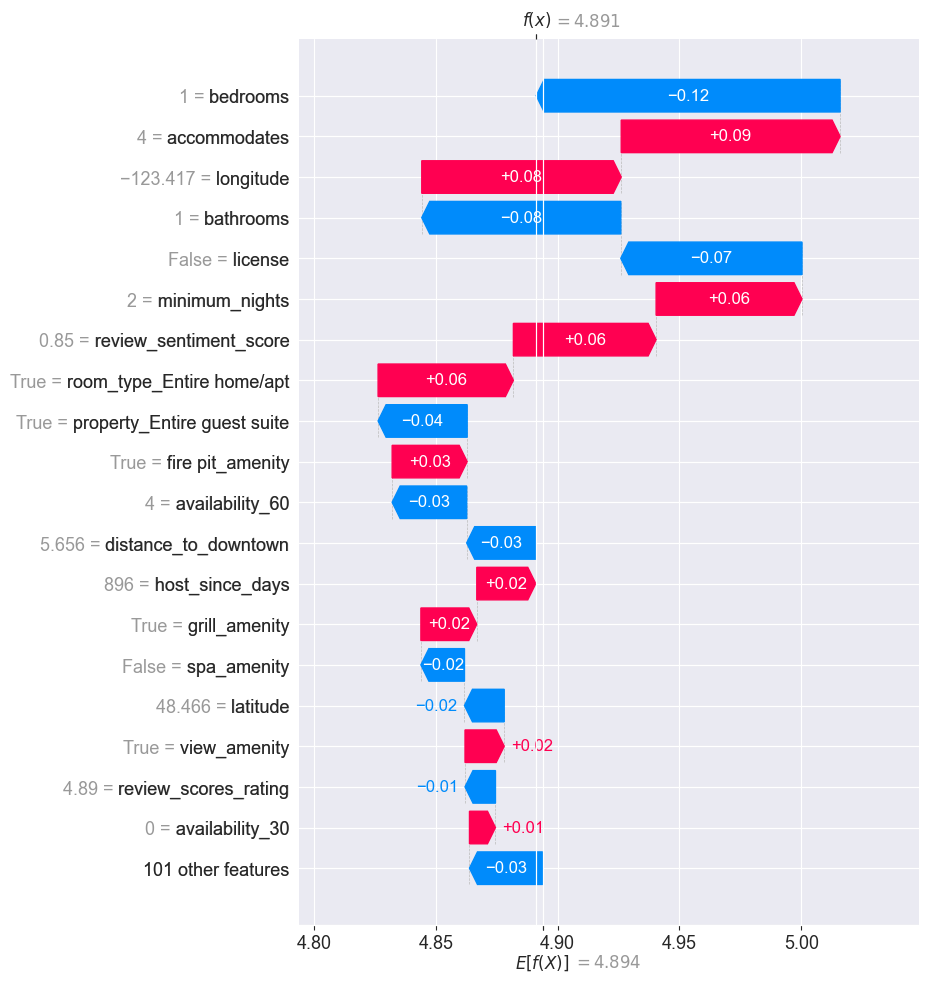

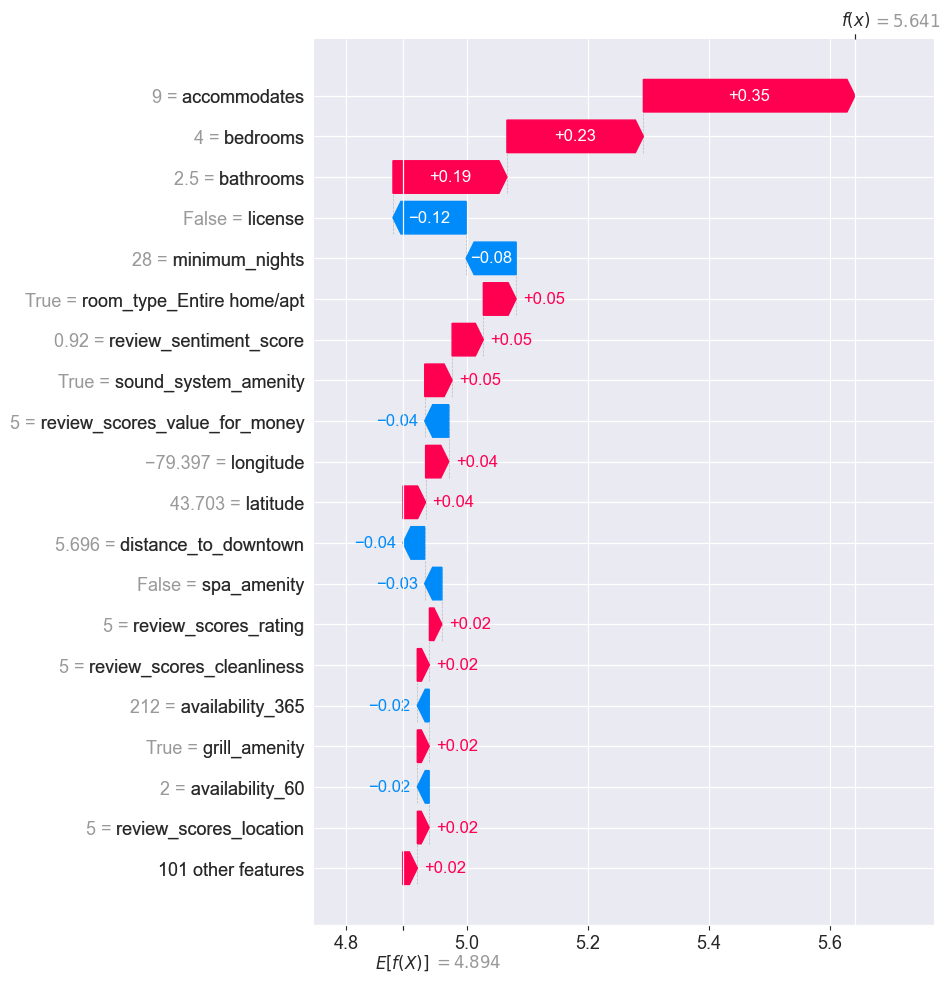

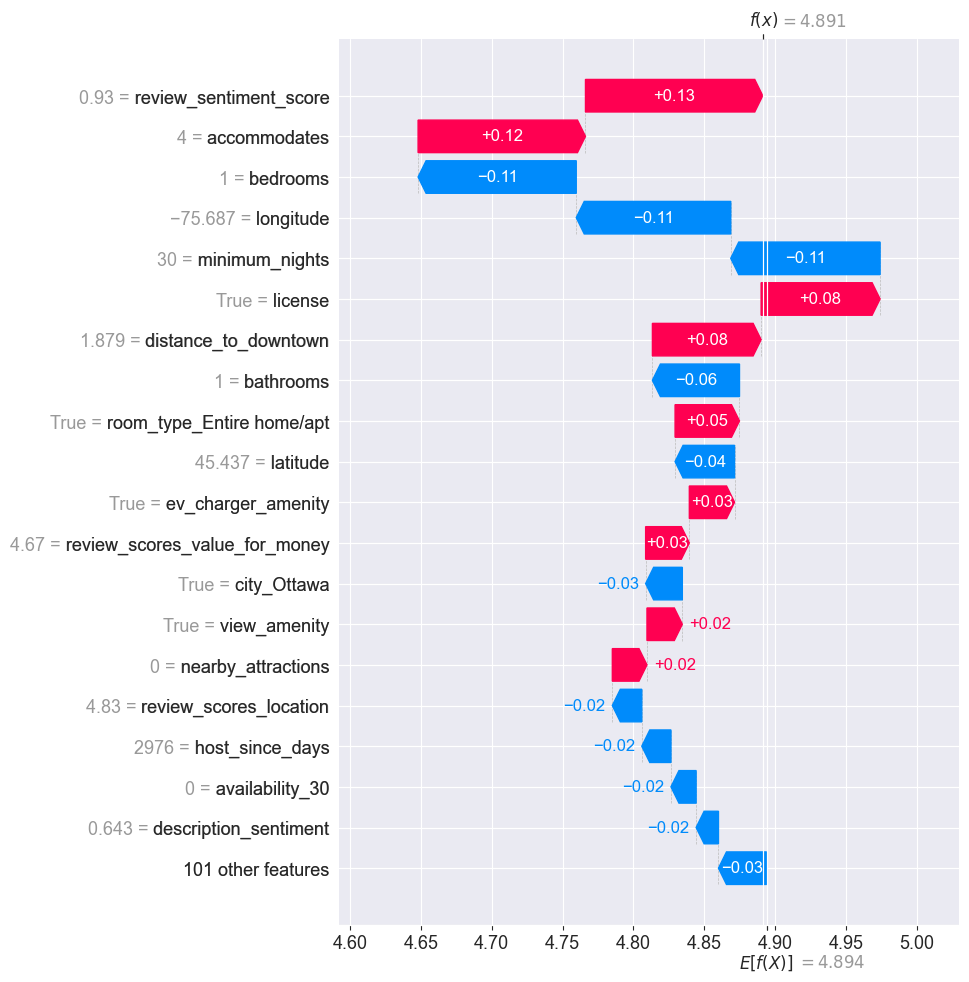

In [105]:
# SHAP values and plots for Local Interpretability of predictions with highest residuals
shap_values = XAI_SHAP(final_model_lgbm, test[0], 'local', 24)
shap_values = XAI_SHAP(final_model_lgbm, test[0], 'local', 165)
shap_values = XAI_SHAP(final_model_lgbm, test[0], 'local', 43)

SHAP Global Interpretation

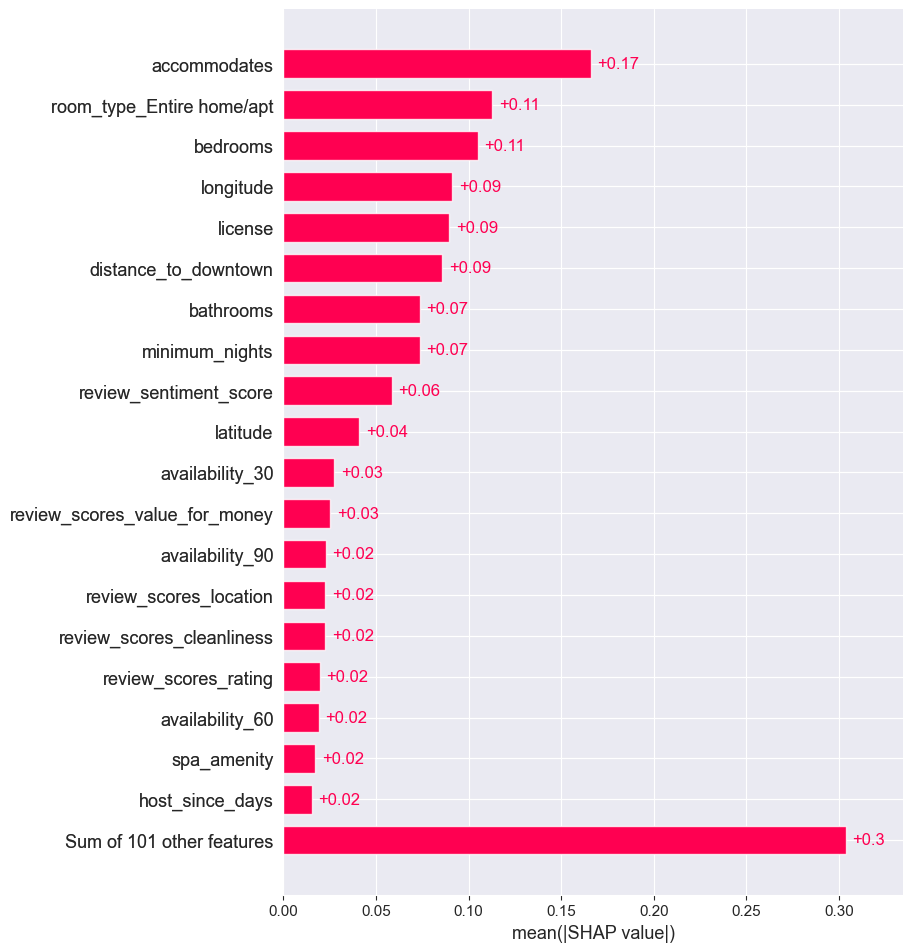

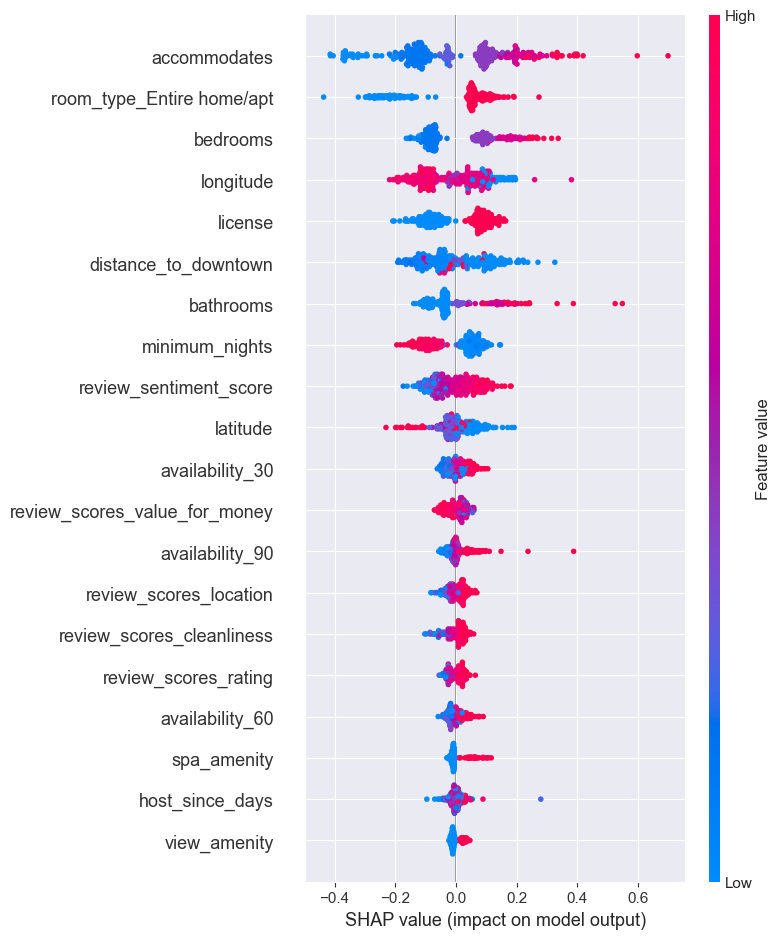

In [106]:
# SHAP values and plots for Global Interpretability
shap_values = XAI_SHAP(final_model_lgbm, test[0], 'global')

<li> Changed how amenities are extracted - reduced overfitting </li>
<li> Used categorical features directly - better model interpretability </li>
<li> Global and local interpretetions showed that last_review_days, first_review_days, and host_listings_count was having a negative effect on price prediction, so we removed that column for better accuracy. </li>
<li> Identified the predictions with highest residuals and interpreted them using SHAP - Results indicate the model's pricing/recommended price is logical, and the original listing price is too high for it's features. </li>
<li> Increased train size - reduced overfitting </li>       
<li> Improved parameters - reduced overfitting </li>

In [107]:
# Tuned Model Building
# Reduced Number of estimators to reduce number of iterations of boosting
# Limited number of leaves to 50
# Limited maximum number of bins
model_lgbm = lgb.LGBMRegressor(max_bin=100, learning_rate=0.01, n_estimators=1000, num_leaves=50, verbose=0, max_depth=-1, random_state=42)

In [108]:
# Encode categorical features
categorical_features = ['property_type', 'city', 'room_type']
for col in categorical_features:
    X_train_selected[col] = X_train_selected[col].astype('category')
    X_test_selected[col] = X_test_selected[col].astype('category')
    
# Convert categorical features to their indices
categorical_feature_indices = [X_train_selected.columns.get_loc(col) for col in categorical_features]

Model Fitting

In [109]:
model_lgbm.fit(X_train_selected, y_train, categorical_feature=categorical_feature_indices)
train_pred_lgbm = model_lgbm.predict(X_train_selected)
test_pred_lgbm = model_lgbm.predict(X_test_selected)

# Evaluate Light GBM
lgbm_train_r2 = r2_score(y_train, train_pred_lgbm)
lgbm_train_mse = mean_squared_error(y_train, train_pred_lgbm)
lgbm_test_r2 = r2_score(y_test, test_pred_lgbm)
lgbm_test_mse = mean_squared_error(y_test, test_pred_lgbm)

# Calculating and printing the evaluation metrices values
print(f'\n--------Tuned Light GBM Train Fitting-----------')
print(f'R2 Score: {lgbm_train_r2}')
print(f'MSE: {lgbm_train_mse}')
print(f'--------Tuned Light GBM Test Fitting-----------')
print(f'R2 Score: {lgbm_test_r2}')
print(f'MSE: {lgbm_test_mse}')

r2_difference = lgbm_train_r2 - lgbm_test_r2
mse_difference = lgbm_train_mse - lgbm_test_mse
print(f'Difference in R2 Score: {r2_difference}')
print(f'Difference in MSE: {mse_difference}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

--------Tuned Light GBM Train Fitting-----------
R2 Score: 0.8266538412052326
MSE: 0.08056480110138237
--------Tuned Light GBM Test Fitting-----------
R2 Score: 0.7630802933424828
MSE: 0.11250096698570224
Difference in R2 Score: 0.06357354786274971
Difference in MSE: -0.03193616588431987


Fitted Global Interpretation

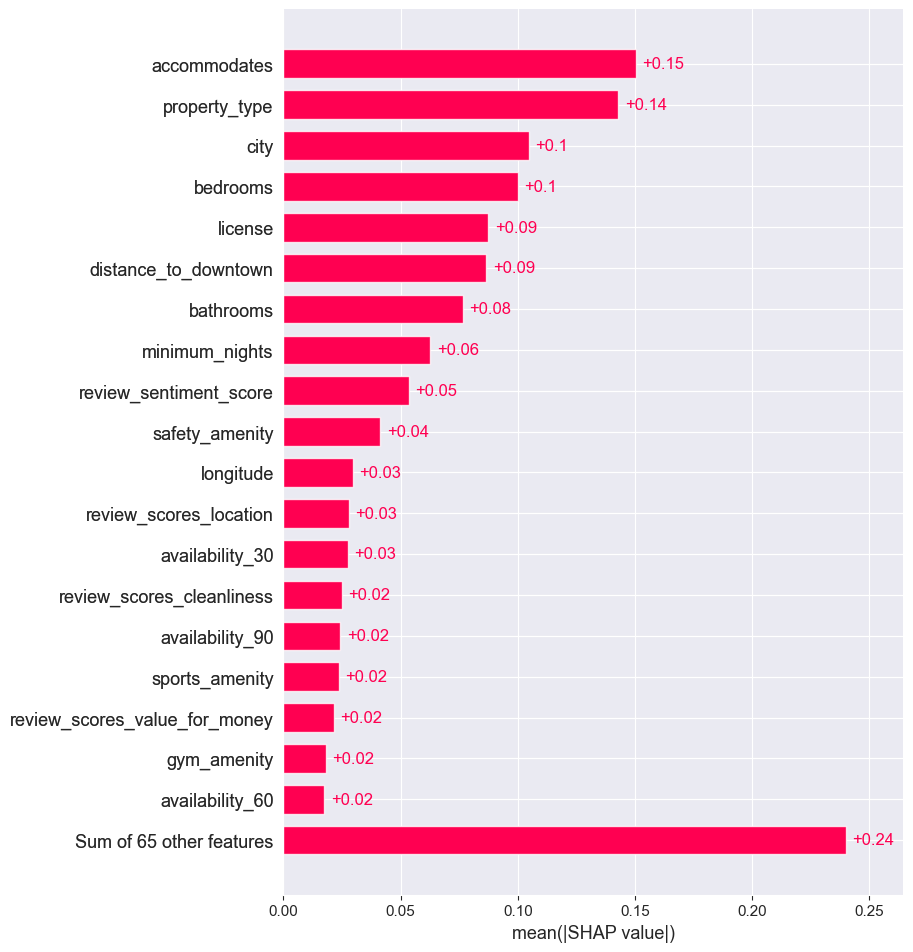

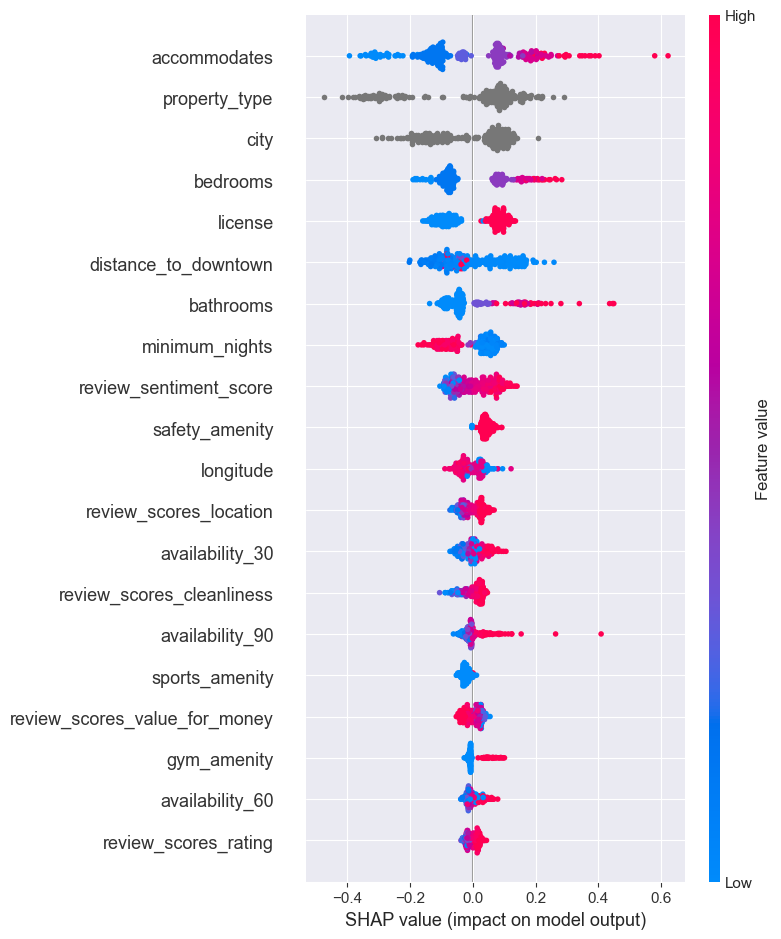

In [110]:
# Stacking features and target for interpretability
test2 = [X_test_selected, y_test]
# SHAP values and plots for Global Interpretability
shap_values = XAI_SHAP(model_lgbm, test2[0], 'global')

LGBM inbuilt feature importance

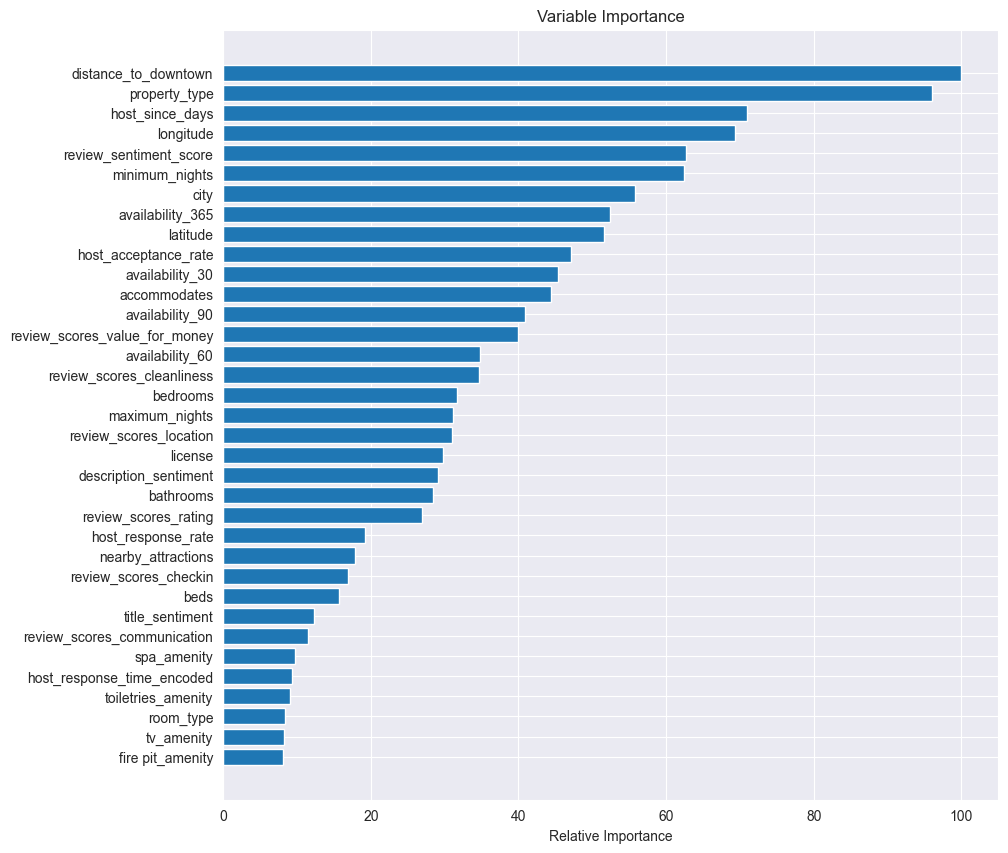

In [111]:
# Plot feature importance
top = 35
feature_importance = model_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (10,10))
plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
plt.yticks(pos[-top:], X_train_selected.columns[sorted_idx][-top:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Comparing metrices after tuning

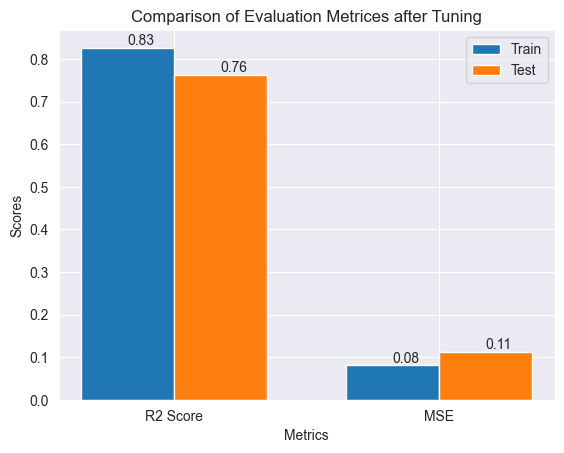

In [112]:
# Data for visualization
metrics = ['R2 Score', 'MSE']
train_scores = [lgbm_train_r2, lgbm_train_mse]
test_scores = [lgbm_test_r2, lgbm_test_mse]

# Setting up the bar width and positions
bar_width = 0.35
index = np.arange(len(metrics))

# Creating the plot
fig, ax = plt.subplots()
train_bar = ax.bar(index, train_scores, bar_width, label='Train')
test_bar = ax.bar(index + bar_width, test_scores, bar_width, label='Test')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrices after Tuning')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# Adding the scores on top of the bars
for bar in train_bar + test_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), va='bottom')

# Display the plot
plt.show()

## Model System Development

We are developing a subsequent model that clusters listings and displays similar listings around the user-created listing.

In [113]:
# Load listing data to airbnb_df
cluster_df = airbnb_df[['id', 'title', 'property_type', 'room_type', 'latitude', 'longitude', 'accommodates', 'minimum_nights', 'amenities', 'price']]

cluster_df = cluster_df.dropna(subset=['price'])

In [114]:
# Create a LabelEncoder instance
label_encoder_property_type = LabelEncoder()
label_encoder_room_type = LabelEncoder()

# Apply label encoding to 'property_type' and 'room_type'
cluster_df['property_type_encoded'] = label_encoder_property_type.fit_transform(cluster_df['property_type'])
cluster_df['room_type_encoded'] = label_encoder_room_type.fit_transform(cluster_df['room_type'])

# Feature Engineering
features = cluster_df[['accommodates', 'room_type_encoded', 'property_type_encoded']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

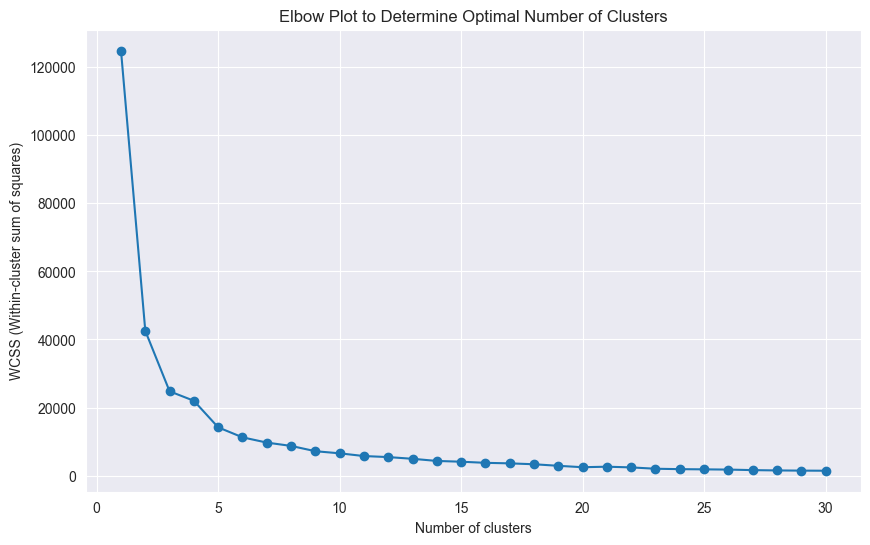

In [115]:
# Determine the ideal number of clusters using the elbow plot
wcss = []
max_clusters = 30
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.title('Elbow Plot to Determine Optimal Number of Clusters')
plt.show()

In [116]:
# Clustering using KMeans
kmeans = KMeans(n_clusters=15, random_state=42)  # Using high cluster number because we want to select very distinct listings
cluster_df['cluster'] = kmeans.fit_predict(features_scaled)

In [117]:
# Example usage: find similar listings for a randomly selected target listing
target_listing_id = np.random.choice(cluster_df['id'])

# Find the cluster of the target listing
target_cluster = cluster_df[cluster_df['id'] == target_listing_id]['cluster'].values[0]

# Get the latitude and longitude of the target listing
target_location = cluster_df[cluster_df['id'] == target_listing_id][['latitude', 'longitude']].values[0]

# Filter the listings that fall into the same cluster
same_cluster_listings = cluster_df[cluster_df['cluster'] == target_cluster]

# Function to check if a listing is within a given radius
def is_within_radius(row, target_location, radius_km):
    listing_location = (row['latitude'], row['longitude'])
    return great_circle(listing_location, target_location).km <= radius_km

# Apply the distance function
same_cluster_listings['within_radius'] = same_cluster_listings.apply(is_within_radius, target_location=target_location, radius_km=2, axis=1)

# Filter listings that are within the 2km radius
within_radius_listings = same_cluster_listings[same_cluster_listings['within_radius']]

# Drop the 'within_radius' column as it's no longer needed
within_radius_listings = within_radius_listings.drop(columns=['within_radius'])

# Exclude the target listing from the final result
final_result = within_radius_listings[within_radius_listings['id'] != target_listing_id]

print(f'{within_radius_listings.shape[0]} similar listings found nearby.')

# Decode the label encoding for 'property_type' and 'room_type'
within_radius_listings['property_type'] = label_encoder_property_type.inverse_transform(
    within_radius_listings['property_type_encoded'])
within_radius_listings['room_type'] = label_encoder_room_type.inverse_transform(
    within_radius_listings['room_type_encoded'])

# Display specified columns
display_columns = ['title', 'property_type', 'room_type', 'accommodates', 'minimum_nights', 'amenities', 'latitude', 'longitude', 'price']
result = within_radius_listings[display_columns]

# Display the result
result.head()

59 similar listings found nearby.


title  \
37743  West view, Transit convenient, clean & comfort...   
37759                  Lovely large room w/ private bath   
37760                  Beautiful room (s) Vancouver Home   
37833                  Gorgeous New House Double Ensuite   
37835                  Gorgeous New House Single Ensuite   

              property_type     room_type  accommodates  minimum_nights  \
37743  Private room in home  Private room             1              30   
37759  Private room in home  Private room             2               2   
37760  Private room in home  Private room             2               2   
37833  Private room in home  Private room             1              31   
37835  Private room in home  Private room             1              31   

                                               amenities  latitude  longitude  \
37743  ["Heating", "Private living room", "Host greet...  49.24356 -123.04757   
37759  ["Bathtub", "Luggage dropoff allowed", "Extra ...  49.22834 -123.03047   
37760  ["Wifi", "Essentials", "Lock on bedroom door",...  49.23034 -123.02971   
37833  ["Luggage dropoff allowed", "Extra pillows and...  49.24976 -123.03547   
37835  ["Luggage dropoff allowed", "Extra pillows and...  49.24958 -123.03590   

       price  
37743   57.0  
37759  158.0  
37760  158.0  
37833   85.0  
37835   75.0